# Fit beta distributions to the simulations
This will require monitoring and quality control and thus an interactive approach

In [3]:
import sqlite3 
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.utils import *
from src.approximation import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

In [1]:
# specify system parameters
params = {
    'N': 10000, # number of nodes
    'K': 100, # number of connections per node
    'mu': 0.2, # fraction of nodes that receive input
    'seed': 1001 # random seed 
}

In [4]:
con=sqlite3.connect('./simulations.db') 
cur = con.cursor()
# load table from database into pandas dataframe
simulations = pd.read_sql_query(f"SELECT * from simulations WHERE N={params['N']} AND K={params['K']} AND mu={params['mu']} AND seed={params['seed']}", con)
beta_approximations = pd.read_sql_query(f"SELECT * from beta_approximations ", con)
beta_approximations = beta_approximations[beta_approximations['simulation_id'].isin(simulations['simulation_id'])]
con.close()

In [5]:
print(f'For specified parameters we have {len(simulations)} simulations and {len(beta_approximations)} beta approximations')
selection = simulations[~simulations['simulation_id'].isin(beta_approximations['simulation_id'])]
print(f'There are {len(selection)} simulations without beta approximation:')
print(selection)

For specified parameters we have 3502 simulations and 3502 beta approximations
There are 0 simulations without beta approximation:
Empty DataFrame
Columns: [simulation_id, N, K, lambda, mu, h, window, seed, raw_file, dataset]
Index: []


## Fit the data with a beta distribution
We are fitting the samples from the activity traces with a beta distribution. Since we are considering mean activity, this matches the support of the beta distribution [0,1] for infinitely large system sizes. For small system sizes, we extend the support for [-1/N, 1+1/N] by setting the `loc` and `scale` parameters of the distribution accordingly. 

Notice: For $\lambda\to 1$ and $h\to 0$ the probability distribution of activity becomes a power law, which cannot be captured by the beta distribution. For the subsequent analysis this is not relevant because we are further convolving the distribution with a Gaussian and consider sufficienty large overlaps such that the tails are less relevant.

In [6]:
con=sqlite3.connect('./simulations.db') 
cur = con.cursor()

# check that table exists
table='beta_approximations'
cur.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table}'")
if len(cur.fetchall())==0:
    # throw error
    raise ValueError(f'Table {table} does not exist in database')

# TODO: would need to actively delete the entry in the database if we want to re-fit
# overwrite=False

# for all simulations in selection, fit the beta distribution and store the parameters in the database
# TODO: check if fit is done before attempting; set a flag to allow for re-fitting
for i, sim in tqdm(selection.iterrows(), total=len(selection)):
    # simulation_id
    simulation_id = sim['simulation_id']
    # discretization from system size
    delta = 1/sim['N']
    # raw_file 
    raw_file = sim['raw_file']
    # dataset in raw_file
    dataset = sim['dataset']
    # load data from dataset in raw_file (hdf5)
    with h5py.File(raw_file, 'r') as file:
        data = np.array(file[dataset])
        # fit beta distribution
        a,b,loc,scale = fit_beta_distribution(data, delta)
        # add result to database
        params_db={'simulation_id':simulation_id, 'a':a, 'b':b, 'loc':loc, 'scale':scale}
        insert_into_database(con, cur, table, params_db)         
con.close()


  1%|▏         | 5/340 [00:00<00:29, 11.50it/s]

100%|██████████| 340/340 [03:45<00:00,  1.51it/s]


## Quality control of beta approximation

In [7]:
con=sqlite3.connect('./simulations.db') 
cur = con.cursor()
beta_approximations = pd.read_sql_query("SELECT * from beta_approximations", con)
con.close()
beta_approximations = beta_approximations[beta_approximations['simulation_id'].isin(selection['simulation_id'])]
df = pd.merge(simulations, beta_approximations, on='simulation_id')
# drop N,K, mu, raw_file, dataset
df

simulation_id      N    K  lambda   mu           h   window  seed  \
0             5779  10000  100  0.0000  0.2   17.782794      1.0  1001   
1             5780  10000  100  0.0000  0.2   17.782794     10.0  1001   
2             5781  10000  100  0.0000  0.2   17.782794    100.0  1001   
3             5782  10000  100  0.0000  0.2   17.782794   1000.0  1001   
4             5783  10000  100  0.0000  0.2   17.782794  10000.0  1001   
..             ...    ...  ...     ...  ...         ...      ...   ...   
335           6364  10000  100  0.9999  0.2  100.000000      1.0  1001   
336           6365  10000  100  0.9999  0.2  100.000000     10.0  1001   
337           6366  10000  100  0.9999  0.2  100.000000    100.0  1001   
338           6367  10000  100  0.9999  0.2  100.000000   1000.0  1001   
339           6368  10000  100  0.9999  0.2  100.000000  10000.0  1001   

                                              raw_file          dataset  \
0    /scratch02.local/johannes/projects/sahel_finit...      samples/1.0   
1    /scratch02.local/johannes/projects/sahel_finit...     samples/10.0   
2    /scratch02.local/johannes/projects/sahel_finit...    samples/100.0   
3    /scratch02.local/johannes/projects/sahel_finit...   samples/1000.0   
4    /scratch02.local/johannes/projects/sahel_finit...  samples/10000.0   
..                                                 ...              ...   
335  /scratch02.local/johannes/projects/sahel_finit...      samples/1.0   
336  /scratch02.local/johannes/projects/sahel_finit...     samples/10.0   
337  /scratch02.local/johannes/projects/sahel_finit...    samples/100.0   
338  /scratch02.local/johannes/projects/sahel_finit...   samples/1000.0   
339  /scratch02.local/johannes/projects/sahel_finit...  samples/10000.0   

                a             b     loc   scale  
0    1.565338e+08  6.259005e+08 -0.0001  1.0002  
1    1.566830e+08  6.264973e+08 -0.0001  1.0002  
2    1.566979e+08  6.265567e+08 -0.0001  1.0002  
3    1.566985e+08  6.265590e+08 -0.0001  1.0002  
4    1.566990e+08  6.265612e+08 -0.0001  1.0002  
..            ...           ...     ...     ...  
335  5.826792e+03  2.915796e+00 -0.0001  1.0002  
336  1.594056e+04  7.976817e+00 -0.0001  1.0002  
337  1.023501e+05  5.121685e+01 -0.0001  1.0002  
338  7.051777e+05  3.528791e+02 -0.0001  1.0002  
339  1.939876e+06  9.707277e+02 -0.0001  1.0002  

[340 rows x 14 columns]

    simulation_id      N    K  lambda   mu           h  window  seed  \
0            5779  10000  100     0.0  0.2   17.782794     1.0  1001   
5            5774  10000  100     0.0  0.2   31.622777     1.0  1001   
10           5784  10000  100     0.0  0.2   56.234133     1.0  1001   
15           5789  10000  100     0.0  0.2  100.000000     1.0  1001   

                                             raw_file      dataset  \
0   /scratch02.local/johannes/projects/sahel_finit...  samples/1.0   
5   /scratch02.local/johannes/projects/sahel_finit...  samples/1.0   
10  /scratch02.local/johannes/projects/sahel_finit...  samples/1.0   
15  /scratch02.local/johannes/projects/sahel_finit...  samples/1.0   

               a             b     loc   scale  
0   1.565338e+08  6.259005e+08 -0.0001  1.0002  
5   1.566989e+08  6.265609e+08 -0.0001  1.0002  
10  1.566989e+08  6.265609e+08 -0.0001  1.0002  
15  1.566989e+08  6.265609e+08 -0.0001  1.0002  
    simulation_id      N    K  lambda   mu 

Text(0, 0.5, 'mean')

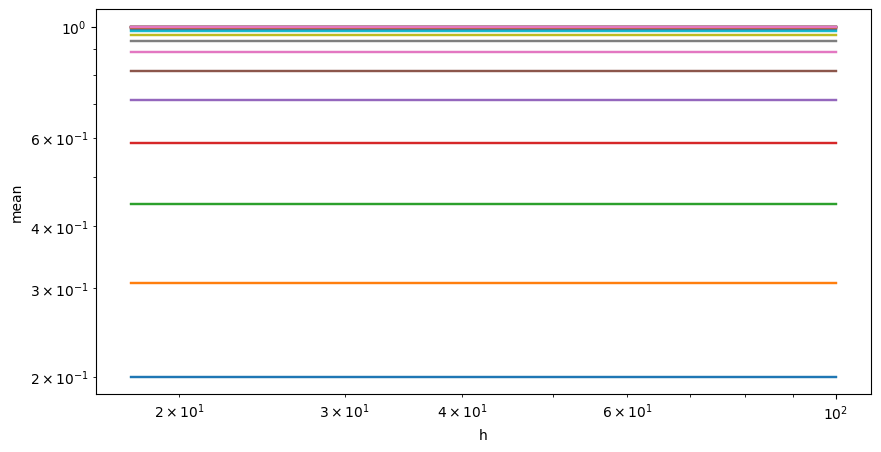

In [8]:
# plot mean as a function of h for different lambda in one plot
fig, ax = plt.subplots(1,1,figsize=(10,5))
for lambda_, group in df.groupby('lambda'):
    # get color according to id in loop
    color = ax._get_lines.get_next_color()
    for window in group['window'].unique():
        sel = group[group['window']==window]
        # sort by h
        sel = sel.sort_values(by='h')
        print(sel)
        hvals, avals, bvals = sel['h'], sel['a'], sel['b']
        # sort hvals 
        ax.plot(hvals, avals/(avals+bvals), color=color)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('h')
ax.set_ylabel('mean')


In [9]:
# y-axis: log10(1-lambda)
xs = np.unique(df['lambda'])
print(xs)
# x-axis: h
ys = np.unique(df['h'])
np.sort(ys)
print(ys)
# for each combination (x,y) plot the mean value of the beta distribution window=1 as a color image on the left and if the relative deviation between windows is larger than 5% as a color image on the right
mean_1 = np.zeros((len(xs), len(ys)))
mean = np.zeros((len(xs), len(ys)))
std  = np.zeros((len(xs), len(ys)))
for (i,x) in tqdm(enumerate(xs), total=len(xs)):
    for (j,y) in enumerate(ys):
        sel = df[(df['h']==y) & (df['lambda']==x)]
        if len(sel)==0:
            continue
        # get a,b parameters for window=1 
        a = sel[sel['window']==1]['a'].values[0]
        b = sel[sel['window']==1]['b'].values[0]
        mean_1[i,j] = a/(a+b)
        mean_local = []
        # get number of windows
        for window in np.unique(sel['window']):
            # get a,b parameters for window
            a = sel[sel['window']==window]['a'].values[0]
            b = sel[sel['window']==window]['b'].values[0]
            mean_local.append(a/(a+b))
        std[i,j] = np.std(mean_local)
        mean[i,j] = np.mean(mean_local)

[0.         0.43765867 0.68377223 0.82217206 0.9        0.94376587
 0.96837722 0.98221721 0.99       0.99437659 0.99683772 0.99822172
 0.999      0.99943766 0.99968377 0.99982217 0.9999    ]
[ 17.7827941   31.6227766   56.23413252 100.        ]


100%|██████████| 17/17 [00:00<00:00, 66.50it/s]


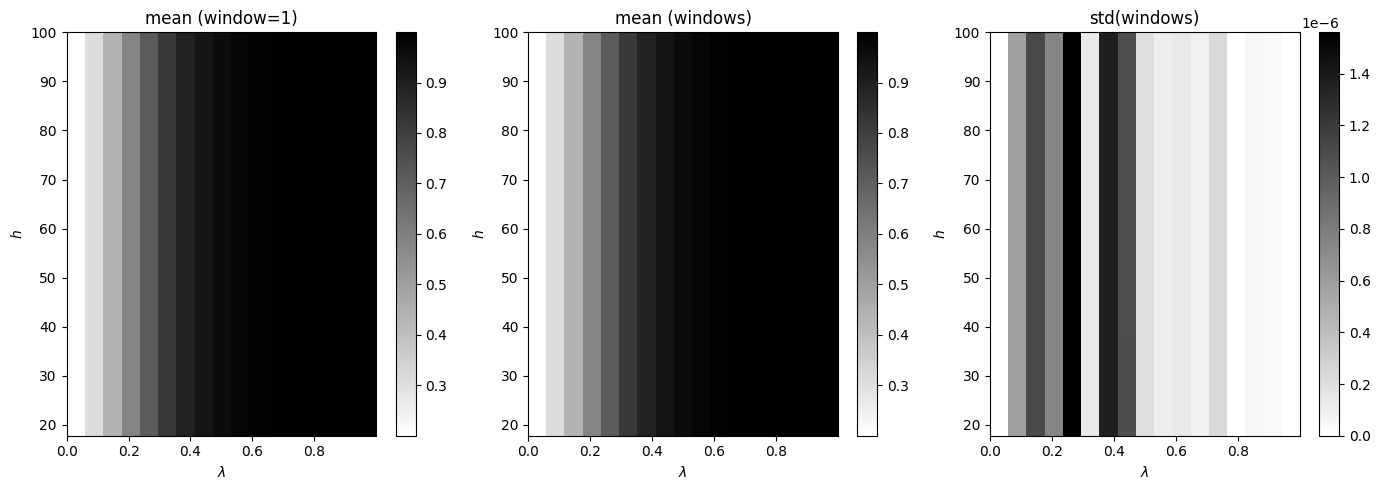

In [10]:
# color plot of mean in left plot
fig, axes = plt.subplots(1,3, figsize=(14,5))
# x,y are linear in log10 space
im = axes[0].imshow(mean_1.T, extent=[xs[0], xs[-1], ys[0], ys[-1]], cmap='gray_r', origin='lower', aspect='auto')
axes[0].set_xlabel('$\lambda$')
axes[0].set_ylabel('$h$')
axes[0].set_title('mean (window=1)')
# show colorbar
cbar = fig.colorbar(im, ax=axes[0])
# mean over windows
im = axes[1].imshow(mean.T, extent=[xs[0], xs[-1], ys[0], ys[-1]], cmap='gray_r', origin='lower', aspect='auto')
axes[1].set_xlabel('$\lambda$')
axes[1].set_ylabel('$h$')
axes[1].set_title('mean (windows)')
# show colorbar
cbar = fig.colorbar(im, ax=axes[1])
# std over windwos
im = axes[2].imshow(std.T, extent=[xs[0], xs[-1], ys[0], ys[-1]], cmap='gray_r', origin='lower', aspect='auto')
axes[2].set_xlabel('$\lambda$')
axes[2].set_ylabel('$h$')
axes[2].set_title('std(windows)')
cbar = fig.colorbar(im, ax=axes[2])
fig.tight_layout()

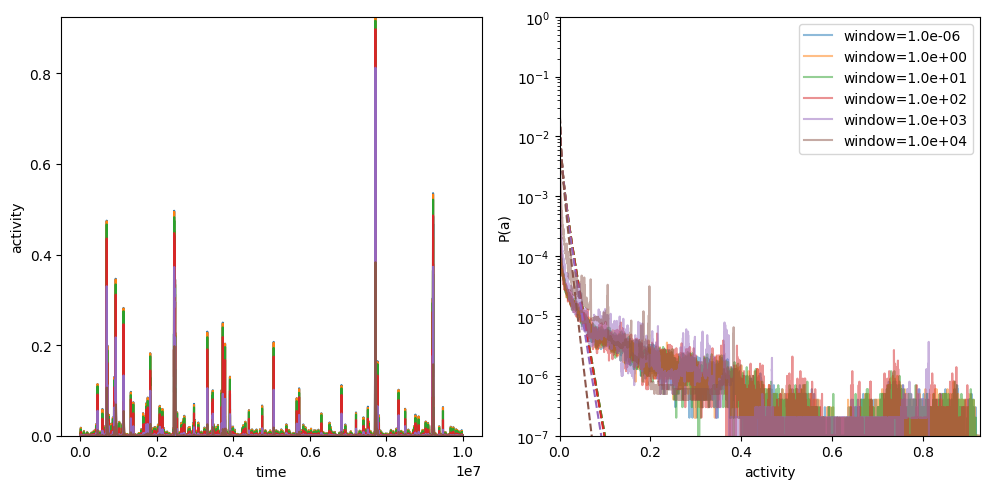

In [71]:
# show comparison for lambda and h examples
fig, axes = plt.subplots(1,2, figsize=(10,5))
range_data = [1,0]
lam = 0.9999
h = 1e-6
sel = df[(df['lambda']==lam) & (df['h']==h)]
windows = sel['window'].values
windows = np.sort(windows)

for (i,window) in enumerate(windows):
    sel_window = sel[sel['window']==window]
    # get data from hdf5 file
    if len(sel_window['raw_file'].values) > 1:
        raise ValueError('Multiple raw files found')
    raw_file = sel_window['raw_file'].values[0]
    dataset = sel_window['dataset'].values[0]
    with h5py.File(raw_file, 'r') as file:
        data = np.array(file[dataset])
        axes[0].plot(data)
        # plot distribution
        N = file.attrs['N']
        delta = 1/N
        support = np.linspace(0,1,N+1)
        pmf_data = np.histogram(data, bins=np.append(support,1+delta)-delta/2, density=False)[0]/len(data)
        ref = axes[1].plot(support, pmf_data, label=f'window={windows[i]:.1e}', alpha=0.5)
        # plot beta distribution
        a = sel_window['a'].values[0]
        b = sel_window['b'].values[0]
        loc = sel_window['loc'].values[0]
        scale = sel_window['scale'].values[0]
        pmf_beta = stats.beta.pdf(support, a,b, loc=loc, scale=scale)
        pmf_beta = pmf_beta/np.sum(pmf_beta)
        axes[1].plot(support,pmf_beta, color=ref[0].get_color(), linestyle='--')
        range_data[0] = min(range_data[0], support[np.nonzero(pmf_data)][0])
        range_data[1] = max(range_data[1], support[np.nonzero(pmf_data)][-1])
axes[0].set_xlabel('time')
axes[0].set_ylabel('activity')
axes[1].set_xlabel('activity')
axes[1].set_ylabel('P(a)')
# set xrange to range of data
axes[1].set_yscale('log')
axes[1].set_ylim([1e-7,1])
axes[1].set_xlim(range_data)
axes[0].set_ylim(range_data)
axes[1].legend()
plt.tight_layout()
plt.show()

## Old version

In [3]:
import h5py

run_old = False
if not run_old:
    # throw error to prevent notebook from running
    raise Exception('Set run_old to True to run cells below')


Exception: Set run_old to True to run cells below

In [ ]:
file_beta = './dat/beta_approximation_simulation.h5'
# make directory if not exist
if not os.path.exists('./dat'):
    os.makedirs('./dat')
# TODO: API is not really human readable yet. Maybe a database/dataframe would be more appropriate? Maybe SQLlite?
    
# df = pd.DataFrame(columns=["window", "lam", "h", "seed", "a", "b", "loc", "scale"])
# df.loc[len(df)] = {"window" : "none", "lam" : 0, "h" : 0, "seed" : 0, "a" : 0, "b" : 0, "loc" : 0, "scale" : 0}
# df

In [ ]:
params = {
    'N': int(1e4),
    'K': 100,
    'mu': 0.02,
}
root='/scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N={N}_K={K}/'.format(**params)
print("system setup:",root)

# get lambda values by iterating over directory and splitting on '='
lambda_dirs = os.listdir(root)
lambdas = [1-float(dir.split("=")[-1]) for dir in  lambda_dirs]
# sort lamdas and lambda_dirs according to value ot lambda
lambdas, lambda_dirs = zip(*sorted(zip(lambdas, lambda_dirs)))
print("available lambda values:")
print(lambdas)

system setup: /scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/
available lambda values:
(0.0, 0.43799999999999994, 0.6839999999999999, 0.8220000000000001, 0.9, 0.9438, 0.9684, 0.9822, 0.99, 0.99438, 0.99684, 0.99822, 0.999, 0.999438, 0.999684, 0.999822, 0.9999)


# Full analysis with quality measures

In [ ]:
seed=1001
for lambda_dir in lambda_dirs:
    path=root+lambda_dir
    print(path)
    filenames=os.listdir(path)

    # filter filenames according to seed
    filenames = [filename for filename in filenames if filename.split("_")[-1].split("=")[-1].split('.')[0]==str(seed)]

    # sort filenames according to h value
    hs = [float(filename.split("_")[-2].split("=")[-1]) for filename in filenames]
    hs, filenames = zip(*sorted(zip(hs, filenames)))

    # loop fit over all filenames    
    for (h,file) in tqdm(zip(hs, filenames), total=len(hs)):
        filename = path+'/'+file
        with h5py.File(filename, 'r') as file:
                N = file.attrs['N']
                lambda_ = file.attrs['lambda']
                seed = file.attrs['seed']
                h=file.attrs['h']
                delta = 1/N
                support = np.linspace(0,1,N+1)
                # iterate over windows
                windows = np.array(file['windows'])
                ref_mean = 0
                for (i,window) in enumerate(windows):
                    data = np.array(file['samples'][f'{window}'])
                    # fit beta distribution
                    a,b,loc,scale = fit_beta_distribution(data, delta)
                    if i==0:
                        ref_mean = np.mean(data)
                    else:
                        # raise warning if mean is deviation from ref_mean
                        if np.fabs(np.mean(data)-ref_mean)>0.05:
                            print(f'WANRING: {window}\t{a:.2e},{b:.2e},{loc},{scale},{a/(a+b)},{np.mean(data)} deviates from reference mean {ref_mean}')
                    # add result to hdf5 file; TODO: check if this is better done with a table maybe even in an sqllite database?
                    with h5py.File(file_beta, 'a') as out:
                        dset = f'{window}/{lambda_}/{h}/{seed}'
                        if dset in out:
                            del out[dset]
                        out.create_dataset(dset, data=np.array([a,b,loc,scale, a/(a+b), np.mean(data)]))            





/scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/1-lambda=1.00e+00


  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:49<00:00,  1.59s/it]


/scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/1-lambda=5.62e-01


100%|██████████| 31/31 [01:07<00:00,  2.18s/it]


/scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/1-lambda=3.16e-01


100%|██████████| 31/31 [01:04<00:00,  2.06s/it]


/scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/1-lambda=1.78e-01


100%|██████████| 31/31 [00:53<00:00,  1.72s/it]


/scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/1-lambda=1.00e-01


100%|██████████| 31/31 [01:08<00:00,  2.21s/it]


/scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/1-lambda=5.62e-02


100%|██████████| 31/31 [01:12<00:00,  2.33s/it]


/scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/1-lambda=3.16e-02


100%|██████████| 31/31 [01:16<00:00,  2.47s/it]


/scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/1-lambda=1.78e-02


100%|██████████| 31/31 [01:04<00:00,  2.08s/it]


/scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/1-lambda=1.00e-02


100%|██████████| 31/31 [01:07<00:00,  2.19s/it]


/scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/1-lambda=5.62e-03


100%|██████████| 31/31 [01:05<00:00,  2.13s/it]


/scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/1-lambda=3.16e-03


100%|██████████| 31/31 [01:23<00:00,  2.69s/it]


/scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/1-lambda=1.78e-03


100%|██████████| 31/31 [01:04<00:00,  2.07s/it]


/scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/1-lambda=1.00e-03


100%|██████████| 31/31 [01:05<00:00,  2.10s/it]


/scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/1-lambda=5.62e-04


100%|██████████| 31/31 [01:59<00:00,  3.87s/it]


/scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/1-lambda=3.16e-04


100%|██████████| 31/31 [02:27<00:00,  4.75s/it]


/scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/1-lambda=1.78e-04


100%|██████████| 31/31 [04:11<00:00,  8.13s/it]


/scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/1-lambda=1.00e-04


100%|██████████| 31/31 [06:22<00:00, 12.34s/it]


## Select a lambda for supervised analysis

In [ ]:
i = 0
print("loading data for lambda={}".format(lambdas[i]))
path=root+lambda_dirs[i]
filenames=os.listdir(path)
hs = [float(filename.split("_")[-2].split("=")[-1]) for filename in filenames]
# sort filenames and h by h
hs, filenames = zip(*sorted(zip(hs, filenames)))
print("path:", path)
# print filenames as a list
print(f"files ({len(filenames)}):")
for (h, filename) in zip(hs, filenames):
    print(f'{h:.2e}\t {filename}')

loading data for lambda=0.0
path: /scratch02.local/johannes/projects/sahel_finite-observation-dynamic-range/N=10000_K=100/1-lambda=1.00e+00
files (51):
1.00e-04	 simulation_mu=0.20_h=1.00e-04_seed=1000.h5
1.26e-04	 simulation_mu=0.20_h=1.26e-04_seed=1000.h5
1.58e-04	 simulation_mu=0.20_h=1.58e-04_seed=1000.h5
2.00e-04	 simulation_mu=0.20_h=2.00e-04_seed=1000.h5
2.51e-04	 simulation_mu=0.20_h=2.51e-04_seed=1000.h5
3.16e-04	 simulation_mu=0.20_h=3.16e-04_seed=1000.h5
3.98e-04	 simulation_mu=0.20_h=3.98e-04_seed=1000.h5
5.01e-04	 simulation_mu=0.20_h=5.01e-04_seed=1000.h5
6.31e-04	 simulation_mu=0.20_h=6.31e-04_seed=1000.h5
7.94e-04	 simulation_mu=0.20_h=7.94e-04_seed=1000.h5
1.00e-03	 simulation_mu=0.20_h=1.00e-03_seed=1000.h5
1.26e-03	 simulation_mu=0.20_h=1.26e-03_seed=1000.h5
1.58e-03	 simulation_mu=0.20_h=1.58e-03_seed=1000.h5
2.00e-03	 simulation_mu=0.20_h=2.00e-03_seed=1000.h5
2.51e-03	 simulation_mu=0.20_h=2.51e-03_seed=1000.h5
3.16e-03	 simulation_mu=0.20_h=3.16e-03_seed=1000.h5


[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	8.75e+00,7.29e+04,-0.0001,1.0002,0.00011995142111513243,1.99796e-05


1.0	1.48e+01,1.23e+05,-0.0001,1.0002,0.00011995122749353214,1.997960684394612e-05
10.0	4.66e+01,3.88e+05,-0.0001,1.0002,0.00011995141767201846,1.997987647040984e-05
100.0	6.58e+01,5.49e+05,-0.0001,1.0002,0.00011995210423641006,1.998056279286196e-05
1000.0	6.87e+01,5.73e+05,-0.0001,1.0002,0.00011995244752066239,1.9980905972155405e-05
10000.0	6.90e+01,5.75e+05,-0.0001,1.0002,0.00011993858898722737,1.9967044650948693e-05


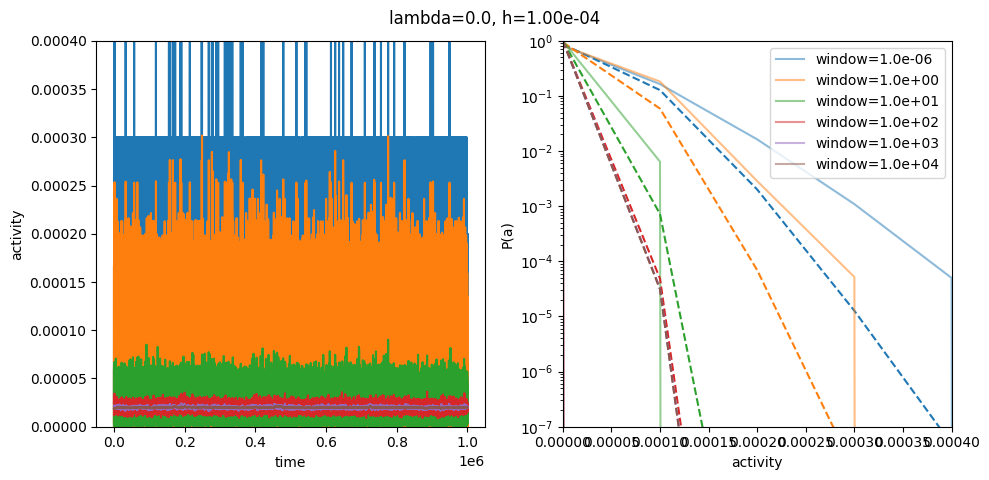

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	7.58e+00,6.06e+04,-0.0001,1.0002,0.00012511983516367152,2.5149e-05
1.0	1.32e+01,1.06e+05,-0.0001,1.0002,0.0001251196063855592,2.5149006843946124e-05
10.0	4.68e+01,3.74e+05,-0.0001,1.0002,0.00012511978750708792,2.5149279961158378e-05
100.0	7.09e+01,5.66e+05,-0.0001,1.0002,0.0001251206334068615,2.5150125532297022e-05
1000.0	7.48e+01,5.98e+05,-0.0001,1.0002,0.00012512032380923642,2.5149815666479186e-05
10000.0	7.52e+01,6.01e+05,-0.0001,1.0002,0.00012510656919178468,2.513605827655293e-05


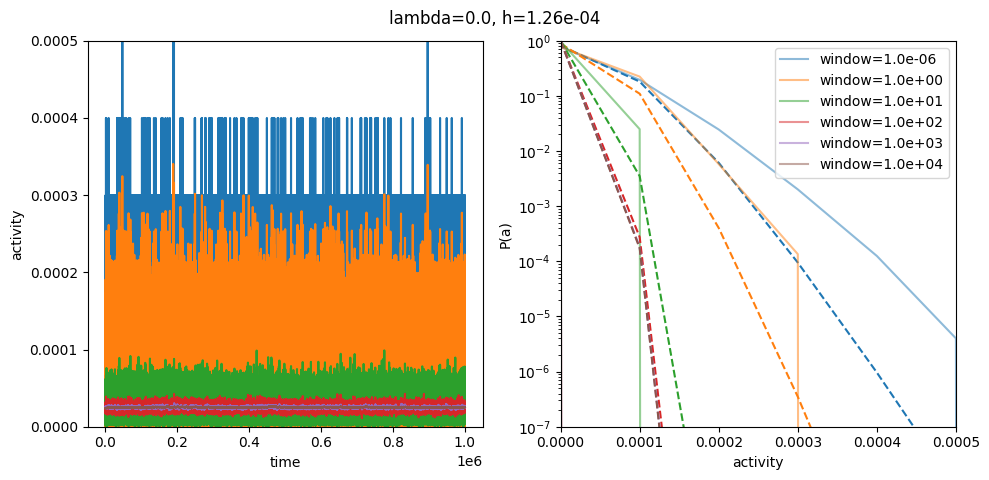

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	6.62e+00,5.03e+04,-0.0001,1.0002,0.00013162698196523038,3.165740000000002e-05
1.0	1.19e+01,9.02e+04,-0.0001,1.0002,0.0001316267173872375,3.165740681041099e-05
10.0	4.72e+01,3.59e+05,-0.0001,1.0002,0.00013162683369328891,3.1657627532571444e-05
100.0	7.74e+01,5.88e+05,-0.0001,1.0002,0.00013162734851131865,3.1658141807666196e-05
1000.0	8.28e+01,6.29e+05,-0.0001,1.0002,0.00013162737484711745,3.1658167928215415e-05
10000.0	8.33e+01,6.33e+05,-0.0001,1.0002,0.0001316151509369464,3.1645941552441834e-05


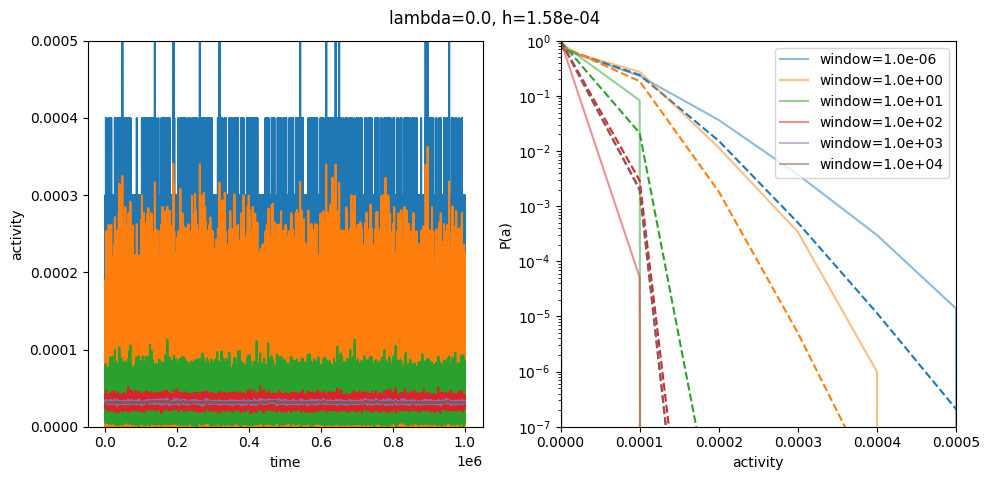

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	5.84e+00,4.17e+04,-0.0001,1.0002,0.00013981098769698098,3.9843000000000005e-05
1.0	1.08e+01,7.70e+04,-0.0001,1.0002,0.00013981070529154167,3.984302059181454e-05
10.0	4.79e+01,3.43e+05,-0.0001,1.0002,0.00013981092095551867,3.9843351577208404e-05
100.0	8.59e+01,6.15e+05,-0.0001,1.0002,0.000139811267176908,3.9843697086428875e-05
1000.0	9.34e+01,6.68e+05,-0.0001,1.0002,0.000139811186708302,3.9843616358588914e-05
10000.0	9.42e+01,6.74e+05,-0.0001,1.0002,0.00013979332919450394,3.98257552481467e-05


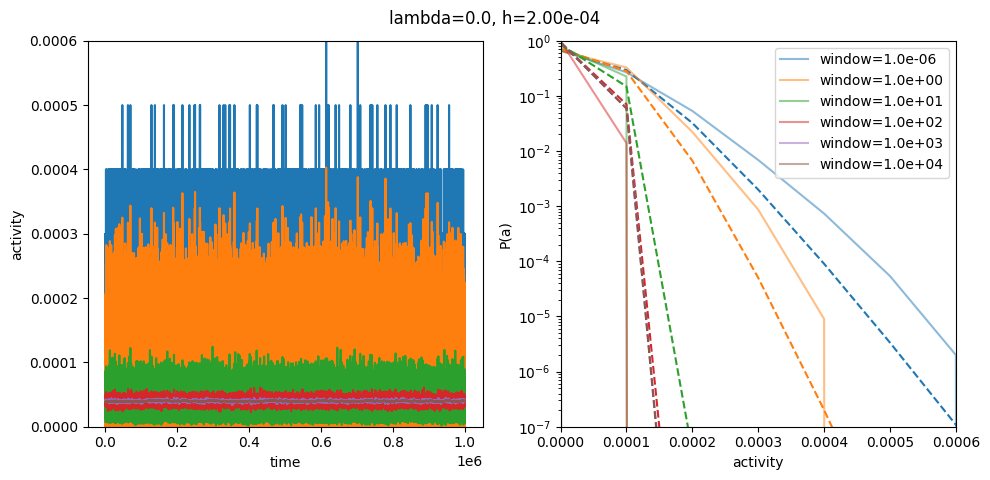

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	5.21e+00,3.47e+04,-0.0001,1.0002,0.00015018483999333572,5.021889999999999e-05
1.0	9.89e+00,6.59e+04,-0.0001,1.0002,0.00015018453715488392,5.0218920597666904e-05
10.0	4.91e+01,3.27e+05,-0.0001,1.0002,0.00015018484046530164,5.021934591839367e-05
100.0	9.71e+01,6.47e+05,-0.0001,1.0002,0.0001501852405747034,5.021974510680031e-05
1000.0	1.08e+02,7.17e+05,-0.0001,1.0002,0.0001501850646019084,5.021956882919326e-05
10000.0	1.09e+02,7.25e+05,-0.0001,1.0002,0.00015015974764621447,5.019424678013788e-05


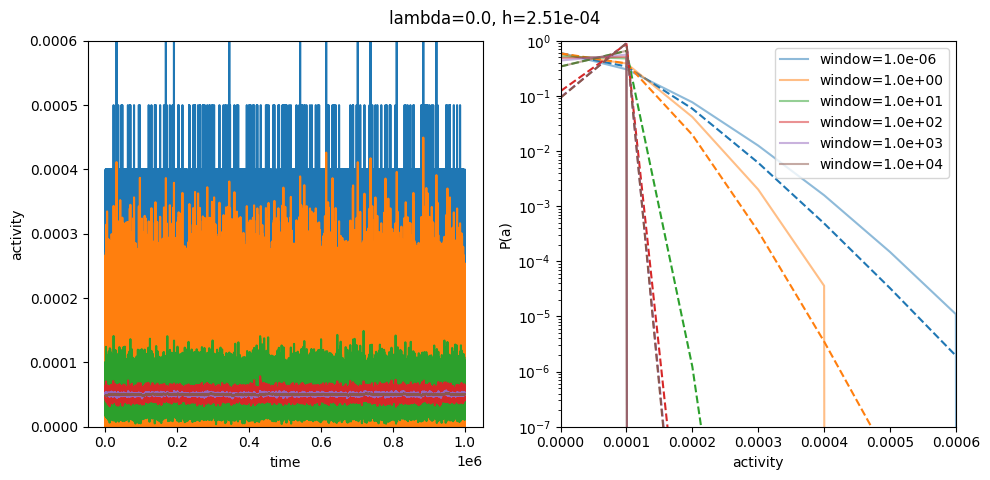

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	4.74e+00,2.90e+04,-0.0001,1.0002,0.0001631464497792136,6.318310000000003e-05
1.0	9.25e+00,5.67e+04,-0.0001,1.0002,0.00016314614453036337,6.318311875316695e-05
10.0	5.07e+01,3.11e+05,-0.0001,1.0002,0.0001631462917194717,6.318338950188568e-05
100.0	1.11e+02,6.83e+05,-0.0001,1.0002,0.00016314649167267913,6.318358828714336e-05
1000.0	1.27e+02,7.78e+05,-0.0001,1.0002,0.00016314600757233333,6.318310379036326e-05
10000.0	1.29e+02,7.88e+05,-0.0001,1.0002,0.0001631162470866249,6.315333732041956e-05


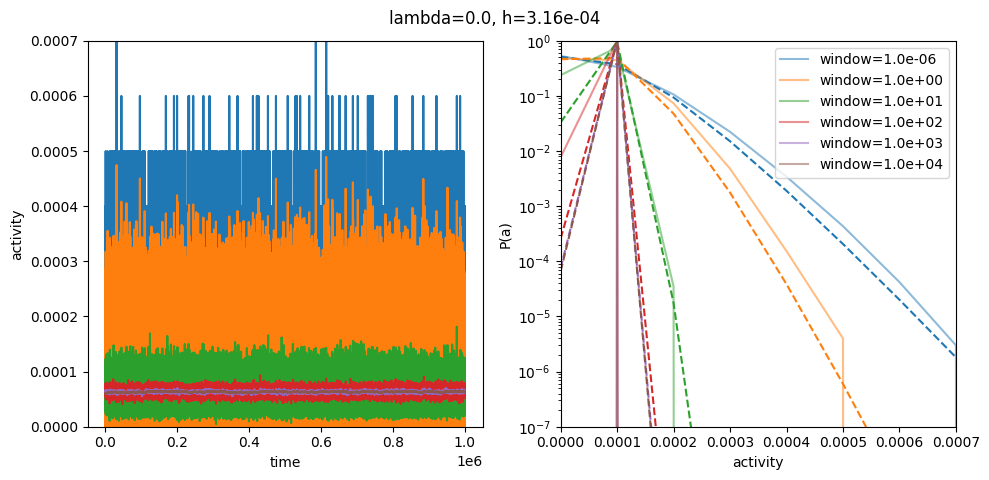

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	4.39e+00,2.45e+04,-0.0001,1.0002,0.0001794837428452759,7.952370000000003e-05
1.0	8.82e+00,4.92e+04,-0.0001,1.0002,0.00017948350713660287,7.952375529331486e-05
10.0	5.31e+01,2.96e+05,-0.0001,1.0002,0.00017948365746868413,7.952402282060343e-05
100.0	1.31e+02,7.28e+05,-0.0001,1.0002,0.0001794835687496335,7.952393261335318e-05
1000.0	1.53e+02,8.55e+05,-0.0001,1.0002,0.0001794820736695111,7.952243690890611e-05
10000.0	1.56e+02,8.69e+05,-0.0001,1.0002,0.00017944173135527836,7.948208649508439e-05


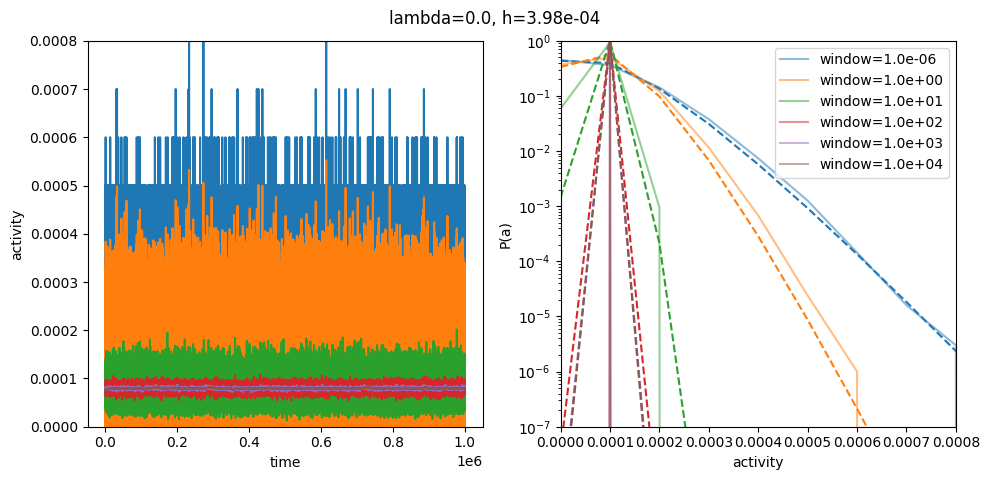

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	4.17e+00,2.08e+04,-0.0001,1.0002,0.00020006981945025183,0.00010011400000000001
1.0	8.63e+00,4.31e+04,-0.0001,1.0002,0.0002000696983082925,0.00010011408236045645
10.0	5.64e+01,2.82e+05,-0.0001,1.0002,0.00020007004257987482,0.00010011452530979657
100.0	1.56e+02,7.80e+05,-0.0001,1.0002,0.00020007016819672817,0.00010011464918964704
1000.0	1.90e+02,9.50e+05,-0.0001,1.0002,0.00020006875814575293,0.00010011323854669052
10000.0	1.94e+02,9.69e+05,-0.0001,1.0002,0.00020002075568464453,0.00010006522645270083


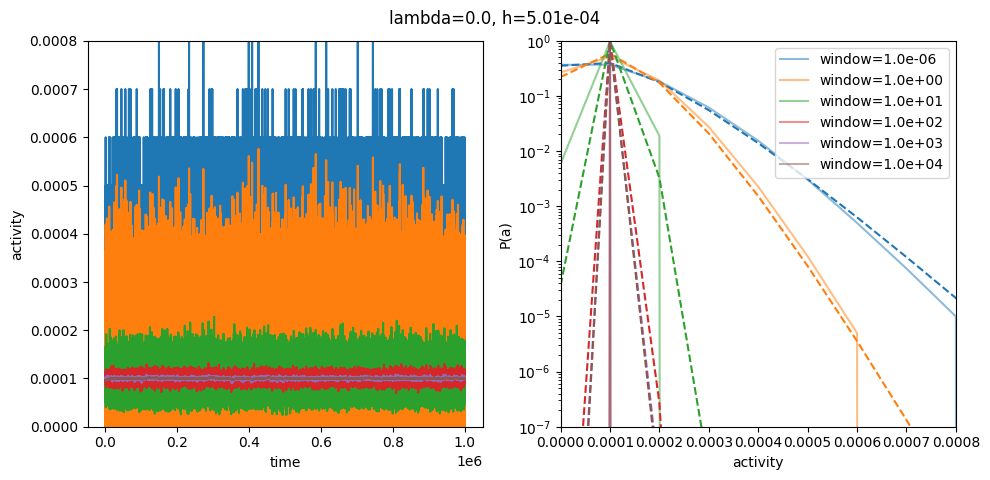

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	4.06e+00,1.80e+04,-0.0001,1.0002,0.00022602733826561803,0.0001260769
1.0	8.66e+00,3.83e+04,-0.0001,1.0002,0.00022602733415053906,0.00012607694166150992
10.0	6.08e+01,2.69e+05,-0.0001,1.0002,0.0002260274942299907,0.00012607716858682798
100.0	1.90e+02,8.39e+05,-0.0001,1.0002,0.0002260272621574921,0.00012607693440366938
1000.0	2.41e+02,1.07e+06,-0.0001,1.0002,0.00022602872346865667,0.00012607839570915032
10000.0	2.48e+02,1.10e+06,-0.0001,1.0002,0.0002259741963358809,0.00012602385763725132


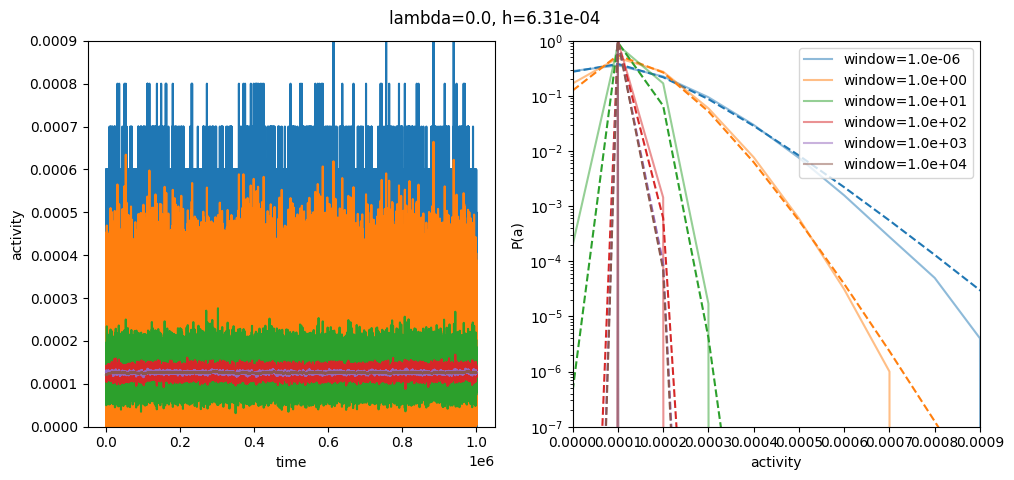

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	4.08e+00,1.57e+04,-0.0001,1.0002,0.00025869211535735023,0.00015874850000000004
1.0	8.93e+00,3.45e+04,-0.0001,1.0002,0.00025869235206363317,0.00015874853612315632
10.0	6.65e+01,2.57e+05,-0.0001,1.0002,0.000258692526025524,0.00015874873368276648
100.0	2.34e+02,9.03e+05,-0.0001,1.0002,0.0002586930205597534,0.00015874922582603446
1000.0	3.14e+02,1.21e+06,-0.0001,1.0002,0.0002586951424526811,0.00015875134784034602
10000.0	3.24e+02,1.25e+06,-0.0001,1.0002,0.0002586229846444711,0.00015867917556996544


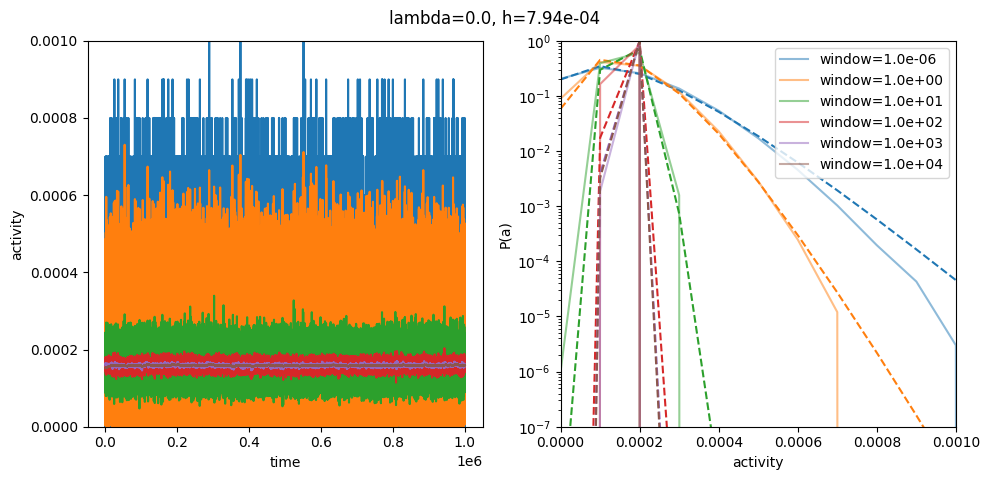

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	4.22e+00,1.41e+04,-0.0001,1.0002,0.00029998446339446206,0.00020004949999999992
1.0	9.47e+00,3.15e+04,-0.0001,1.0002,0.00029998499932283395,0.000200049499416031
10.0	7.41e+01,2.47e+05,-0.0001,1.0002,0.00029998527149248134,0.00020004973788116448
100.0	2.93e+02,9.78e+05,-0.0001,1.0002,0.0002999858726120693,0.00020005033633063002
1000.0	4.19e+02,1.39e+06,-0.0001,1.0002,0.00029998776505063367,0.00020005222885276683
10000.0	4.36e+02,1.45e+06,-0.0001,1.0002,0.0002998935949326335,0.0001999580398748515


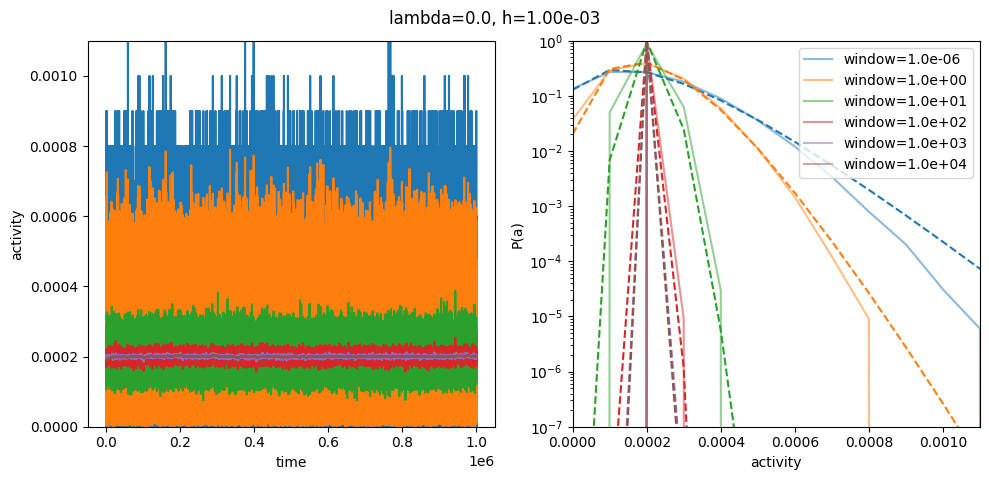

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	4.51e+00,1.28e+04,-0.0001,1.0002,0.00035161997261707803,0.00025169579999999997
1.0	1.03e+01,2.92e+04,-0.0001,1.0002,0.00035162092870793783,0.0002516958177131671
10.0	8.36e+01,2.38e+05,-0.0001,1.0002,0.0003516211392295117,0.0002516959327008537
100.0	3.70e+02,1.05e+06,-0.0001,1.0002,0.00035162015883991976,0.00025169494931598276
1000.0	5.67e+02,1.61e+06,-0.0001,1.0002,0.00035162427409934915,0.0002516990651172393
10000.0	5.97e+02,1.70e+06,-0.0001,1.0002,0.0003515056525683987,0.00025158041983912104


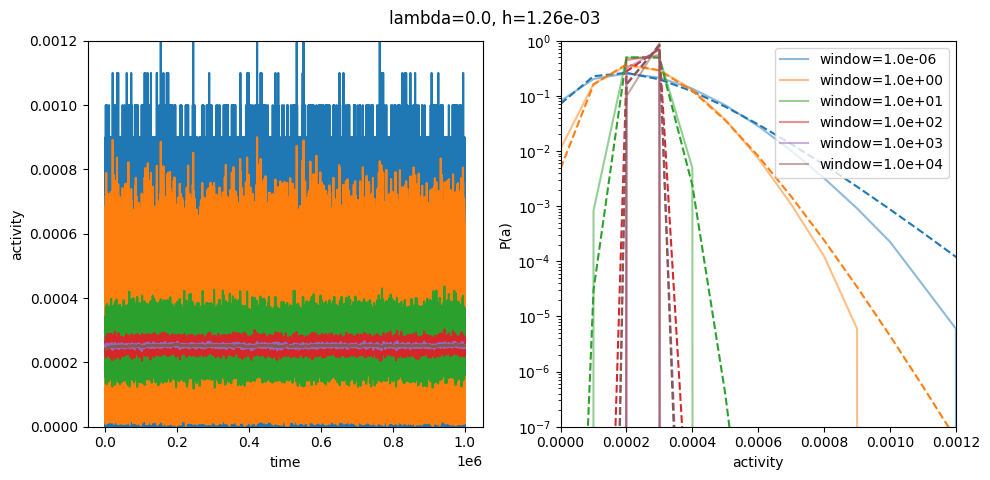

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	4.98e+00,1.20e+04,-0.0001,1.0002,0.0004166781754112501,0.0003167674999999999
1.0	1.15e+01,2.75e+04,-0.0001,1.0002,0.00041667956297498156,0.0003167675236972044
10.0	9.62e+01,2.31e+05,-0.0001,1.0002,0.0004166800719969221,0.0003167678773718493
100.0	4.73e+02,1.14e+06,-0.0001,1.0002,0.00041667913212885537,0.00031676693429774606
1000.0	7.85e+02,1.88e+06,-0.0001,1.0002,0.00041668414170502896,0.00031677194462905806
10000.0	8.41e+02,2.02e+06,-0.0001,1.0002,0.00041663098186856565,0.00031671877413323675


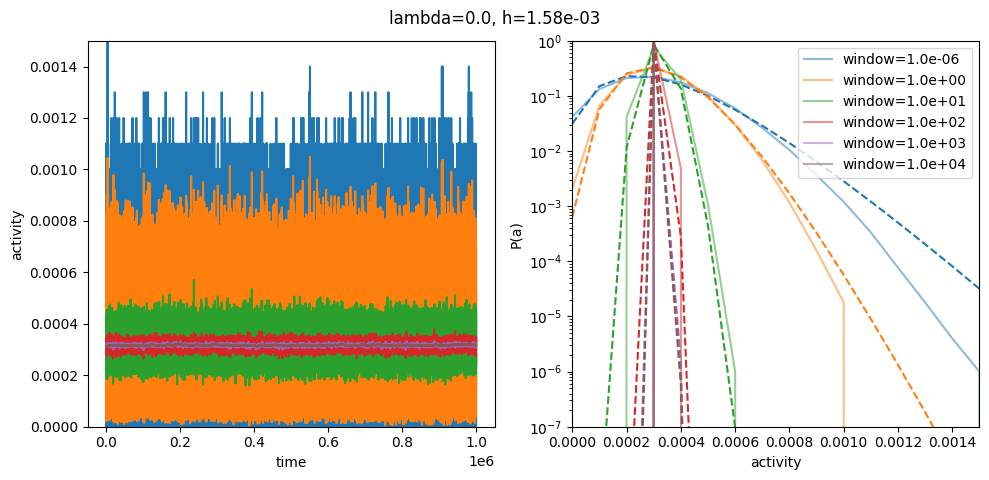

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	5.66e+00,1.13e+04,-0.0001,1.0002,0.0004984837524068151,0.0003985899000000002
1.0	1.31e+01,2.62e+04,-0.0001,1.0002,0.0004984855094994165,0.00039858989323015106
10.0	1.12e+02,2.25e+05,-0.0001,1.0002,0.0004984859213756839,0.0003985900880233975
100.0	6.09e+02,1.22e+06,-0.0001,1.0002,0.0004984846352759971,0.00039858879846194057
1000.0	1.10e+03,2.20e+06,-0.0001,1.0002,0.000498487234678083,0.00039859139816381345
10000.0	1.20e+03,2.41e+06,-0.0001,1.0002,0.000498442491294577,0.00039854664581055255


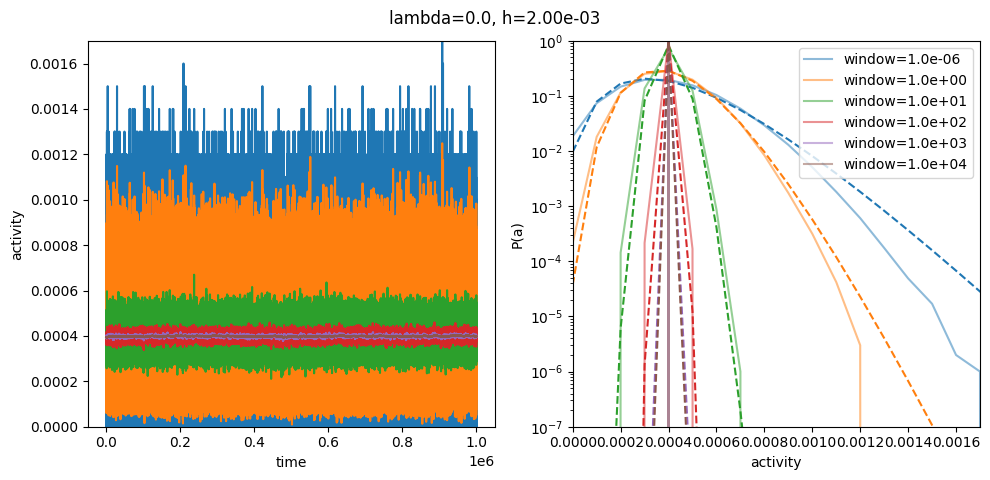

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	6.59e+00,1.09e+04,-0.0001,1.0002,0.0006015941419207195,0.0005017213000000003
1.0	1.52e+01,2.52e+04,-0.0001,1.0002,0.0006015962176460572,0.0005017212823133128
10.0	1.33e+02,2.20e+05,-0.0001,1.0002,0.0006015969144118398,0.000501721703915568
100.0	7.91e+02,1.31e+06,-0.0001,1.0002,0.0006015958761867283,0.0005017206616154782
1000.0	1.57e+03,2.61e+06,-0.0001,1.0002,0.0006015950022256343,0.0005017197872234751
10000.0	1.74e+03,2.90e+06,-0.0001,1.0002,0.0006015120140334971,0.0005016367824211775


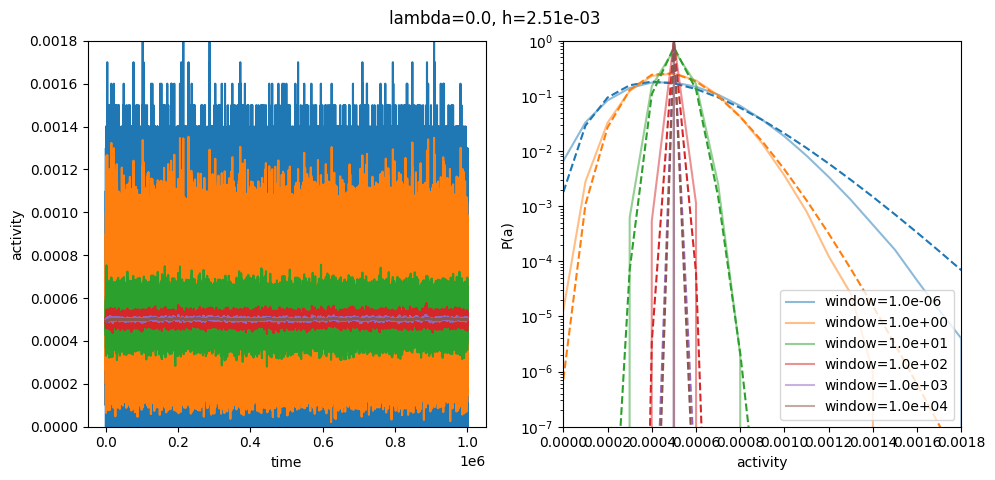

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	7.82e+00,1.07e+04,-0.0001,1.0002,0.0007311920673114478,0.0006313454000000003
1.0	1.79e+01,2.44e+04,-0.0001,1.0002,0.0007311943960731427,0.0006313454264675582
10.0	1.59e+02,2.17e+05,-0.0001,1.0002,0.0007311952685550905,0.0006313459777066668
100.0	1.02e+03,1.40e+06,-0.0001,1.0002,0.0007311925131304896,0.0006313432178136187
1000.0	2.27e+03,3.10e+06,-0.0001,1.0002,0.0007311906874302769,0.0006313413915409942
10000.0	2.56e+03,3.50e+06,-0.0001,1.0002,0.0007310431545181017,0.0006311938291126355


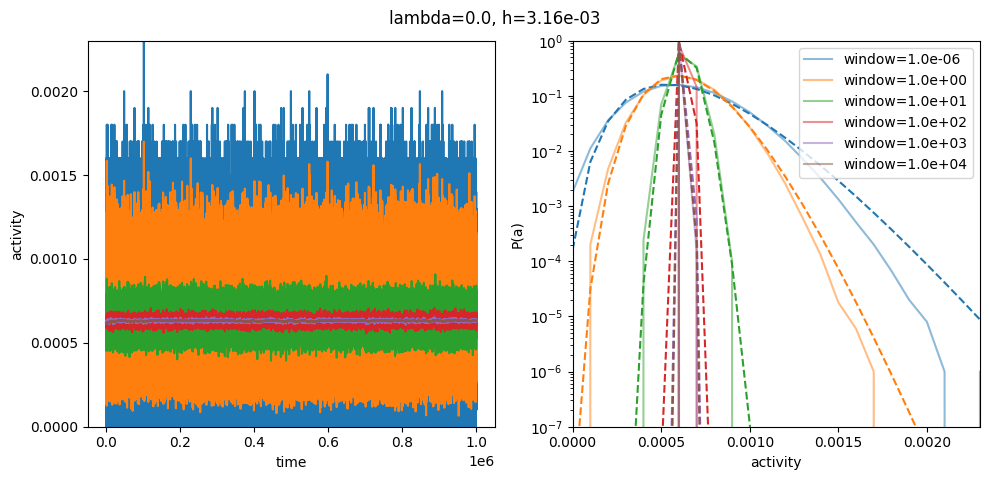

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	9.43e+00,1.05e+04,-0.0001,1.0002,0.0008941820217130711,0.0007943681000000003
1.0	2.13e+01,2.39e+04,-0.0001,1.0002,0.0008941846362932207,0.0007943682996476018
10.0	1.91e+02,2.14e+05,-0.0001,1.0002,0.0008941856438163857,0.0007943689518595811
100.0	1.32e+03,1.48e+06,-0.0001,1.0002,0.0008941835076377065,0.0007943668105177616
1000.0	3.27e+03,3.65e+06,-0.0001,1.0002,0.0008941825360593434,0.0007943658385175914
10000.0	3.78e+03,4.22e+06,-0.0001,1.0002,0.0008939651708789727,0.0007941484298725379


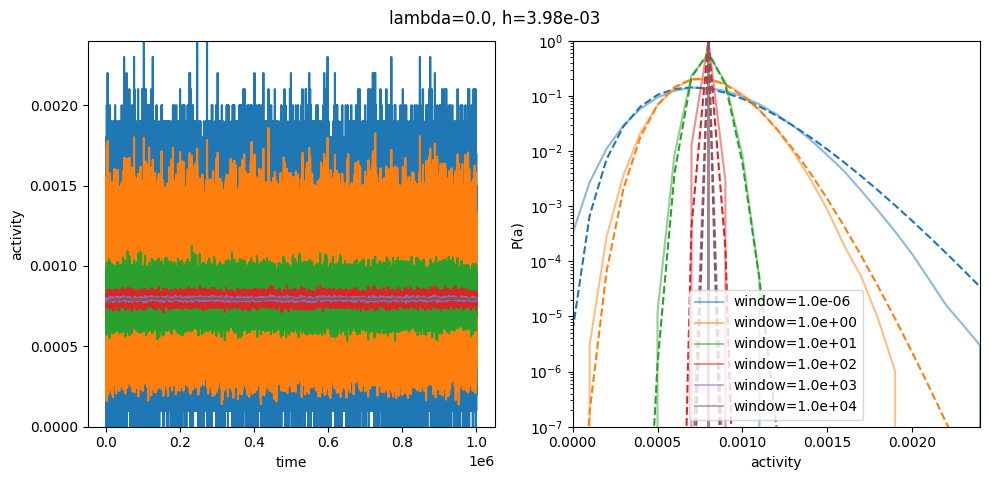

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	1.15e+01,1.04e+04,-0.0001,1.0002,0.001099221377260843,0.0009994486
1.0	2.58e+01,2.34e+04,-0.0001,1.0002,0.001099224133900583,0.000999448844304564
10.0	2.32e+02,2.10e+05,-0.0001,1.0002,0.001099225179303769,0.0009994494958662815
100.0	1.71e+03,1.55e+06,-0.0001,1.0002,0.001099222752835296,0.0009994470634836566
1000.0	4.73e+03,4.30e+06,-0.0001,1.0002,0.0010992165597416624,0.0009994408689909628
10000.0	5.67e+03,5.16e+06,-0.0001,1.0002,0.0010989926537312382,0.0009992169182073017


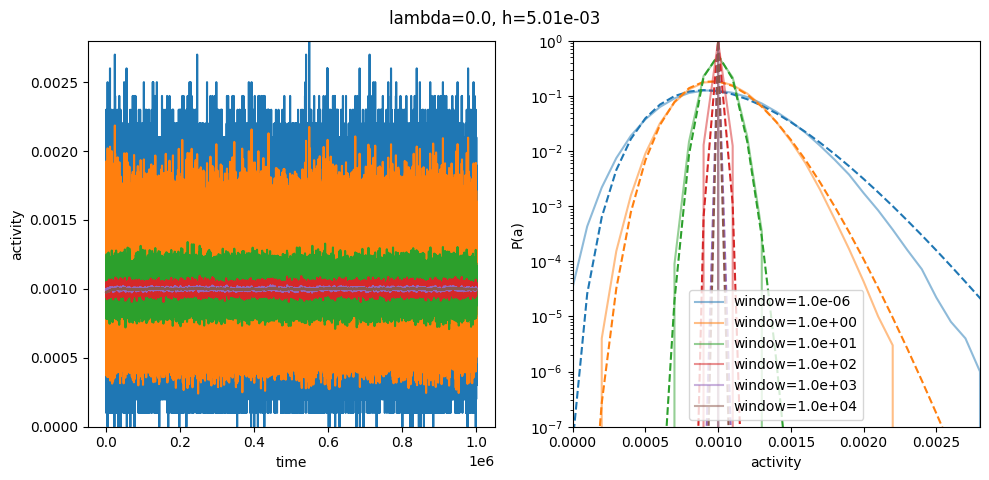

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	1.41e+01,1.03e+04,-0.0001,1.0002,0.0013570204459200307,0.0012572993000000005
1.0	3.14e+01,2.31e+04,-0.0001,1.0002,0.0013570233398618168,0.0012572996345052811
10.0	2.85e+02,2.10e+05,-0.0001,1.0002,0.0013570250172814634,0.0012573008943935304
100.0	2.23e+03,1.64e+06,-0.0001,1.0002,0.0013570235478096136,0.0012572994185731452
1000.0	3.89e+03,2.86e+06,-0.0001,1.0002,0.0013570307218395625,0.0012572943476370098
10000.0	8.50e+03,6.26e+06,-0.0001,1.0002,0.0013567330975735822,0.0012570089101384683


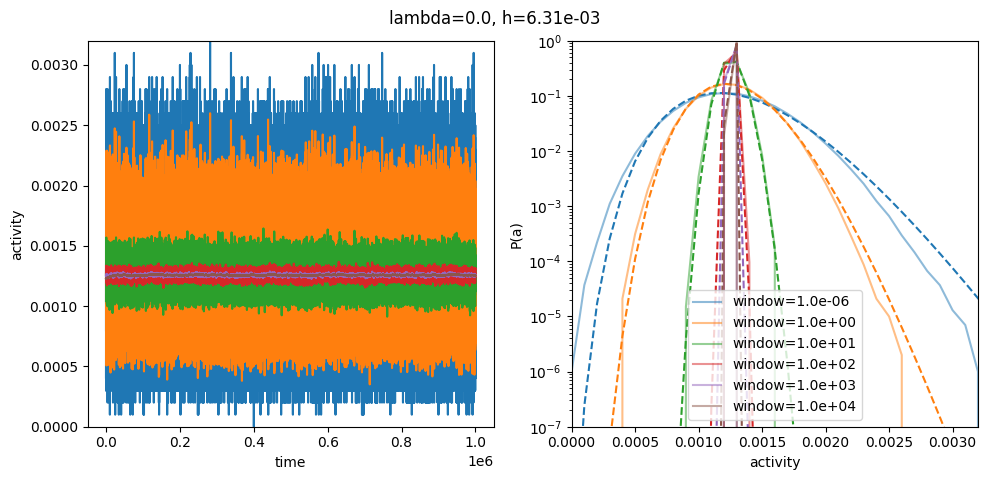

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	1.73e+01,1.03e+04,-0.0001,1.0002,0.0016813719519148788,0.0015817157999999999
1.0	3.84e+01,2.28e+04,-0.0001,1.0002,0.0016813751660908574,0.001581716361290198
10.0	3.52e+02,2.09e+05,-0.0001,1.0002,0.0016813768267770154,0.0015817175748976246
100.0	2.89e+03,1.71e+06,-0.0001,1.0002,0.0016813762803113313,0.001581717021652713
1000.0	9.96e+03,5.91e+06,-0.0001,1.0002,0.001681384680173301,0.0015817254230357605
10000.0	1.29e+04,7.64e+06,-0.0001,1.0002,0.001681091505904638,0.0015814321901432154


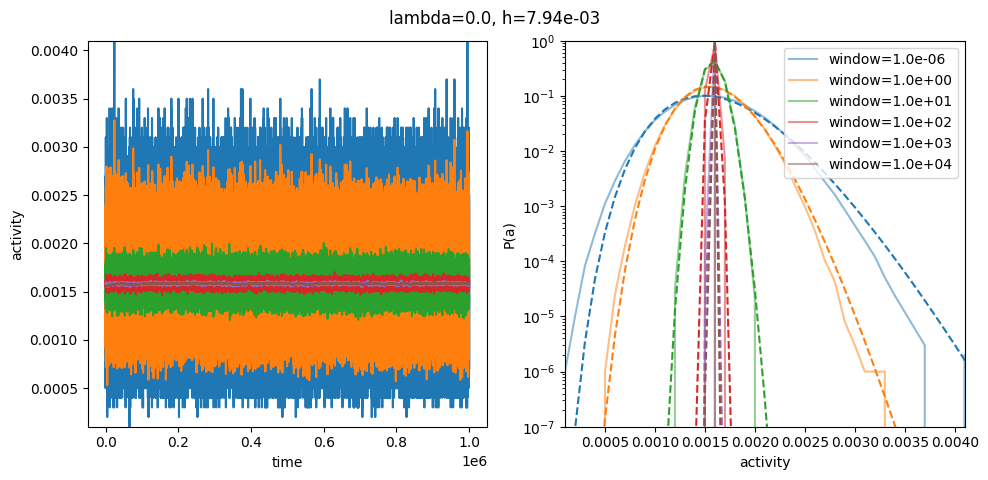

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	2.14e+01,1.02e+04,-0.0001,1.0002,0.0020887970375389263,0.0019892224000000007
1.0	4.73e+01,2.26e+04,-0.0001,1.0002,0.002088800374169244,0.001989223073605418
10.0	4.34e+02,2.07e+05,-0.0001,1.0002,0.00208880241948381,0.0019892246517042252
100.0	3.70e+03,1.77e+06,-0.0001,1.0002,0.002088803403874978,0.0019892256306379068
1000.0	1.45e+04,6.92e+06,-0.0001,1.0002,0.0020888187434040255,0.0019892409730746584
10000.0	2.00e+04,9.56e+06,-0.0001,1.0002,0.00208865490042142,0.0019890770973172833


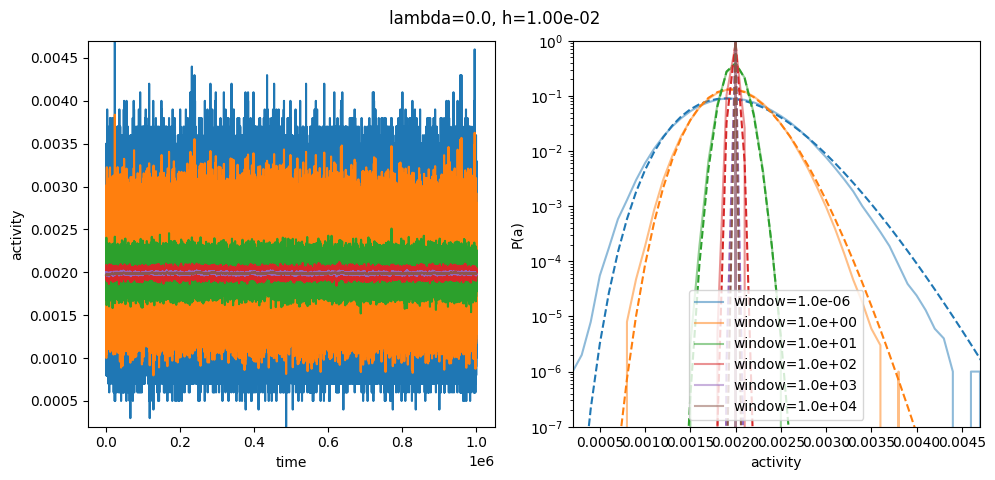

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	2.67e+01,1.02e+04,-0.0001,1.0002,0.0026005979276843925,0.0025011256000000005
1.0	5.87e+01,2.25e+04,-0.0001,1.0002,0.002600601183518053,0.0025011262305645295
10.0	5.39e+02,2.07e+05,-0.0001,1.0002,0.00260060205230375,0.0025011266436932894
100.0	4.68e+03,1.80e+06,-0.0001,1.0002,0.0026006007234694413,0.0025011253096520773
1000.0	2.04e+04,7.83e+06,-0.0001,1.0002,0.002600610715418006,0.0025011353034813744
10000.0	1.58e+04,6.05e+06,-0.0001,1.0002,0.0026003304867289853,0.0025008427724363892


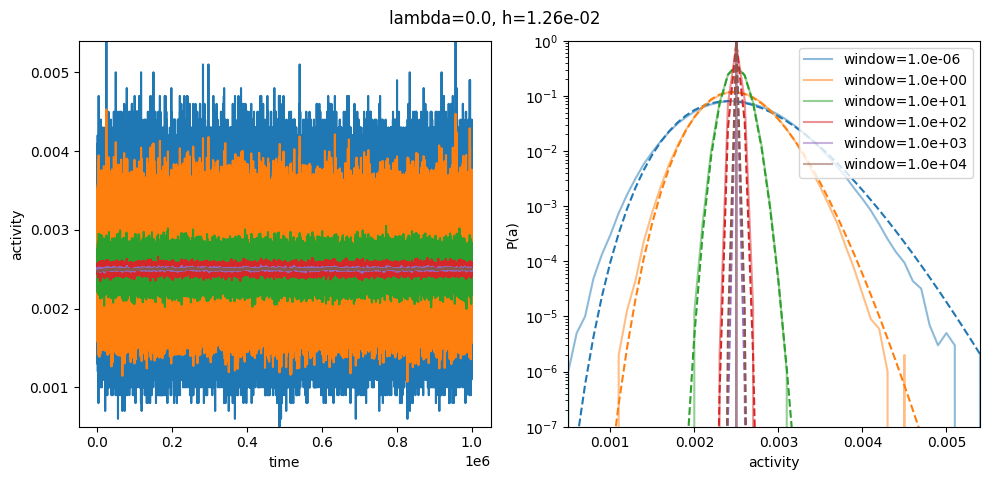

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	3.33e+01,1.02e+04,-0.0001,1.0002,0.0032428921063074063,0.003143548300000001
1.0	7.30e+01,2.24e+04,-0.0001,1.0002,0.0032428953670631602,0.003143548890213793
10.0	6.72e+02,2.07e+05,-0.0001,1.0002,0.0032428961153255515,0.0031435491680298047
100.0	5.94e+03,1.83e+06,-0.0001,1.0002,0.003242897188976862,0.0031435502344265057
1000.0	2.88e+04,8.84e+06,-0.0001,1.0002,0.0032429091606948415,0.0031435622084454795
10000.0	4.72e+04,1.45e+07,-0.0001,1.0002,0.0032427362160039794,0.003143389229155813


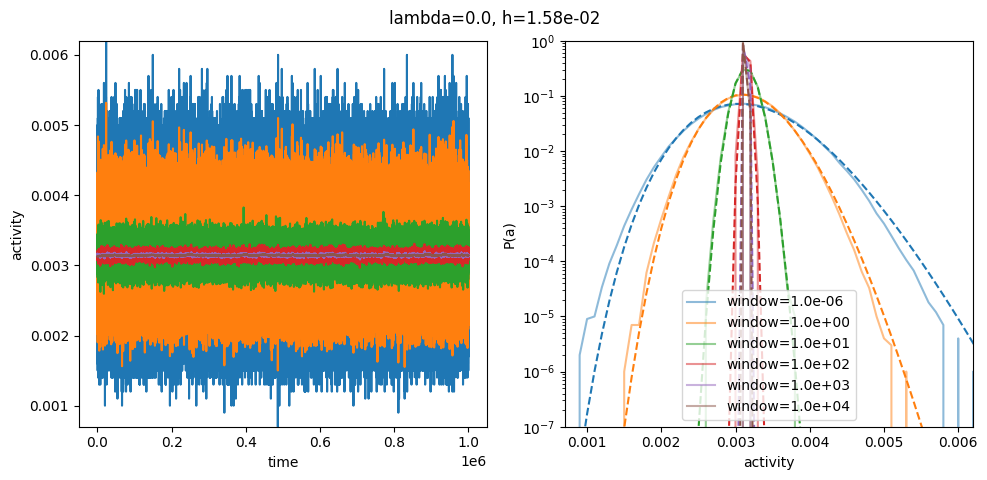

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	4.16e+01,1.02e+04,-0.0001,1.0002,0.004048966813358874,0.003949784200000001
1.0	9.11e+01,2.24e+04,-0.0001,1.0002,0.0040489697346862245,0.003949784476677238
10.0	8.39e+02,2.06e+05,-0.0001,1.0002,0.00404896915076913,0.003949783418902588
100.0	6.91e+03,1.70e+06,-0.0001,1.0002,0.004048983103438323,0.003949785119694741
1000.0	4.00e+04,9.85e+06,-0.0001,1.0002,0.004048985435538354,0.0039497996985420345
10000.0	3.75e+04,9.21e+06,-0.0001,1.0002,0.004048623716259057,0.003949425660601005


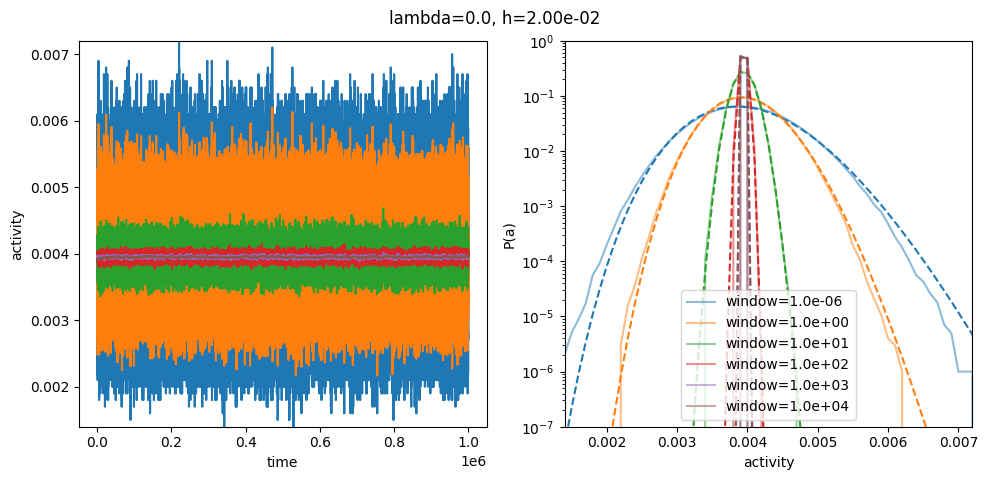

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	5.21e+01,1.03e+04,-0.0001,1.0002,0.005058803109558574,0.004959822500000001
1.0	1.14e+02,2.24e+04,-0.0001,1.0002,0.00505880621299406,0.0049598229461537925
10.0	1.05e+03,2.06e+05,-0.0001,1.0002,0.0050588055497324215,0.004959821786149238
100.0	9.57e+03,1.88e+06,-0.0001,1.0002,0.005058807291302181,0.004959823518878409
1000.0	5.66e+04,1.11e+07,-0.0001,1.0002,0.005058825131311699,0.004959841362262236
10000.0	1.11e+05,2.18e+07,-0.0001,1.0002,0.005058954656992843,0.004959970913830277


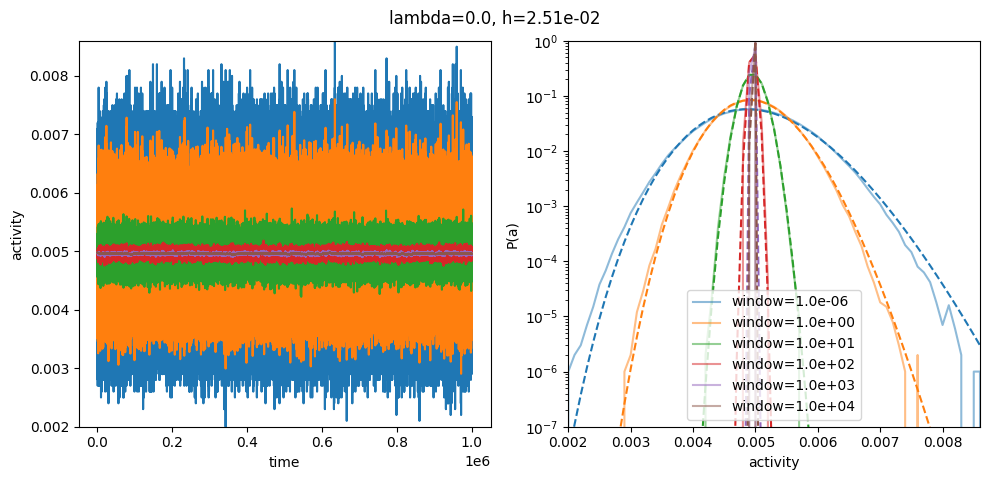

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	6.54e+01,1.03e+04,-0.0001,1.0002,0.006323196478291296,0.006224468799999998
1.0	1.42e+02,2.24e+04,-0.0001,1.0002,0.006323199492723612,0.006224469122329436
10.0	1.32e+03,2.07e+05,-0.0001,1.0002,0.006323196685501137,0.006224465799584155
100.0	1.15e+04,1.81e+06,-0.0001,1.0002,0.006323206350942219,0.006224463212054883
1000.0	7.92e+04,1.24e+07,-0.0001,1.0002,0.006323203996969012,0.0062244731036777004
10000.0	1.70e+05,2.67e+07,-0.0001,1.0002,0.006323182727473337,0.006224451829924355


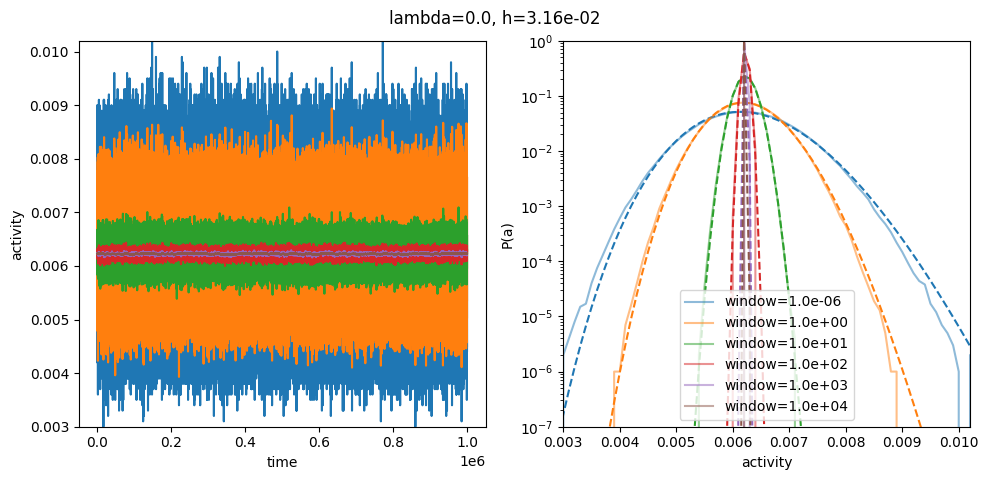

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	8.21e+01,1.03e+04,-0.0001,1.0002,0.007902664501619807,0.007804252699999998
1.0	1.79e+02,2.25e+04,-0.0001,1.0002,0.007902667321851733,0.007804252869360304
10.0	1.65e+03,2.08e+05,-0.0001,1.0002,0.007902662421148225,0.007804247425824342
100.0	1.57e+04,1.97e+06,-0.0001,1.0002,0.007902653458611686,0.007804238455089661
1000.0	1.09e+05,1.37e+07,-0.0001,1.0002,0.007902659160500139,0.0078042441582373105
10000.0	2.57e+05,3.22e+07,-0.0001,1.0002,0.007902812883981942,0.0078043979124616915


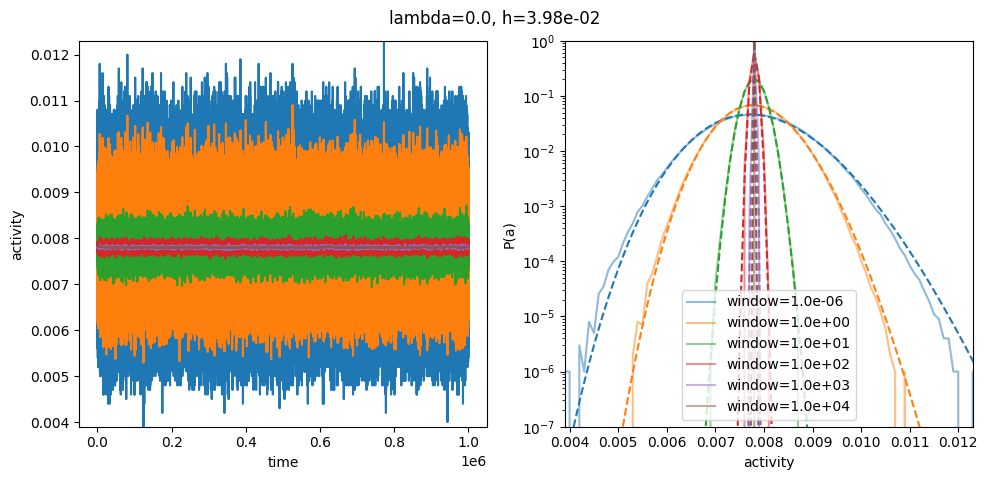

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	1.03e+02,1.04e+04,-0.0001,1.0002,0.009873422804285976,0.009775405099999995
1.0	2.25e+02,2.26e+04,-0.0001,1.0002,0.009873425300968571,0.009775405006983375
10.0	2.08e+03,2.08e+05,-0.0001,1.0002,0.009873420200712048,0.00977539935631816
100.0	1.96e+04,1.96e+06,-0.0001,1.0002,0.009873412330513932,0.009775391479013785
1000.0	1.44e+05,1.44e+07,-0.0001,1.0002,0.009873429174488942,0.009775408326237738
10000.0	3.77e+05,3.78e+07,-0.0001,1.0002,0.009873620191374603,0.009775599381318622


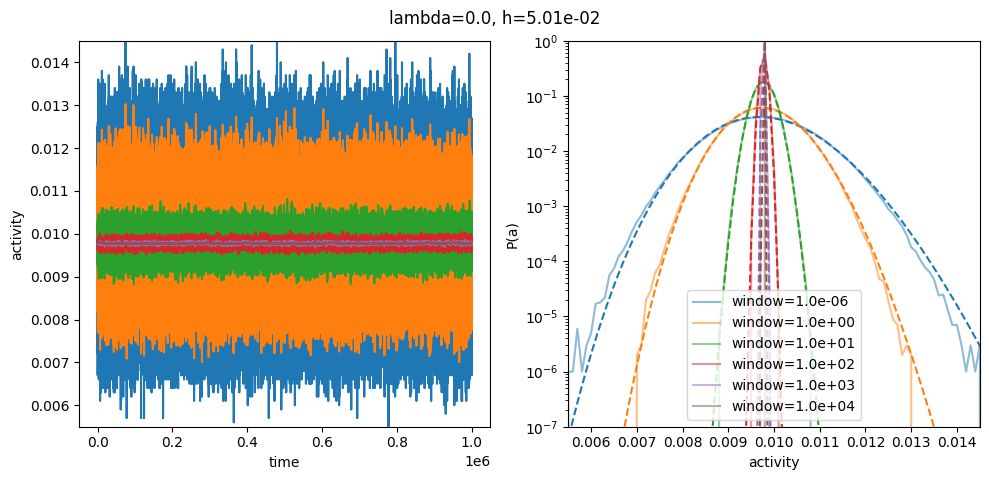

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	1.30e+02,1.04e+04,-0.0001,1.0002,0.012325323728020381,0.012227796299999998
1.0	2.83e+02,2.27e+04,-0.0001,1.0002,0.012325326556386547,0.012227796636597869
10.0	2.61e+03,2.09e+05,-0.0001,1.0002,0.012325323853947035,0.01222779338993026
100.0	2.40e+04,1.92e+06,-0.0001,1.0002,0.012325328477796979,0.012227785763354489
1000.0	1.93e+05,1.54e+07,-0.0001,1.0002,0.012325333967599206,0.012227803500308046
10000.0	5.68e+05,4.55e+07,-0.0001,1.0002,0.012325593677590318,0.01222806326222018


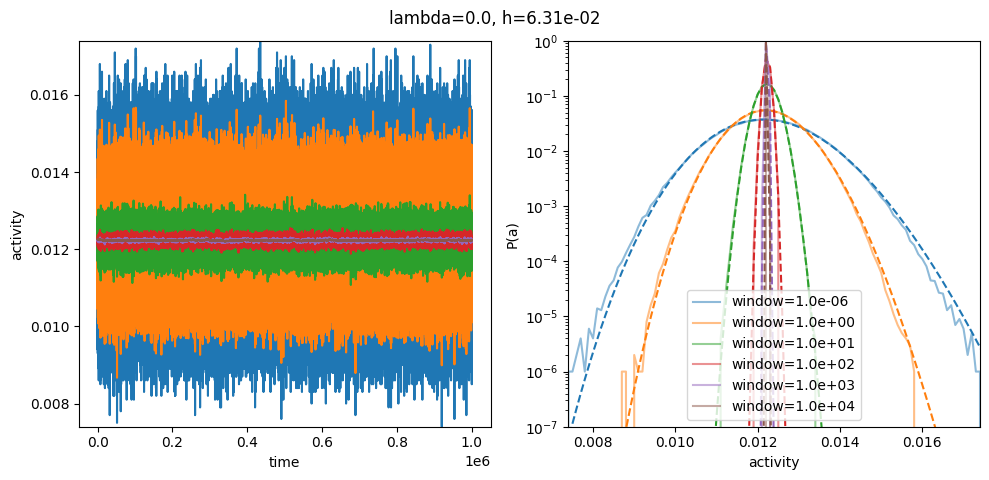

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	1.64e+02,1.05e+04,-0.0001,1.0002,0.0153670808341319,0.0152701617
1.0	3.56e+02,2.28e+04,-0.0001,1.0002,0.015367084056132272,0.015270162488326848
10.0	3.27e+03,2.10e+05,-0.0001,1.0002,0.01536708294492551,0.015270160831680252
100.0	2.81e+04,1.80e+06,-0.0001,1.0002,0.015367063374653395,0.015270150831091879
1000.0	2.54e+05,1.63e+07,-0.0001,1.0002,0.015367094415579081,0.015270172300409737
10000.0	4.80e+05,3.08e+07,-0.0001,1.0002,0.015367633678074602,0.015270699424387121


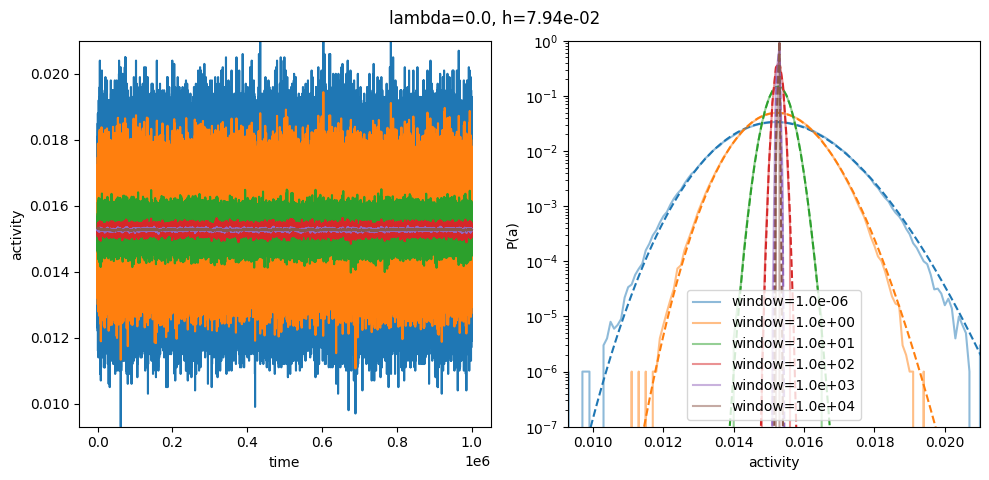

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	2.08e+02,1.07e+04,-0.0001,1.0002,0.019128063808177328,0.019031896999999985
1.0	4.50e+02,2.31e+04,-0.0001,1.0002,0.019128067889575755,0.019031898544404752
10.0	4.16e+03,2.13e+05,-0.0001,1.0002,0.01912806969231284,0.01903189977906849
100.0	4.02e+04,2.06e+06,-0.0001,1.0002,0.0191280647621886,0.01903189484156473
1000.0	3.42e+05,1.75e+07,-0.0001,1.0002,0.019128103144499562,0.019031933231055124
10000.0	1.24e+06,6.38e+07,-0.0001,1.0002,0.019128610720373578,0.01903244090841359


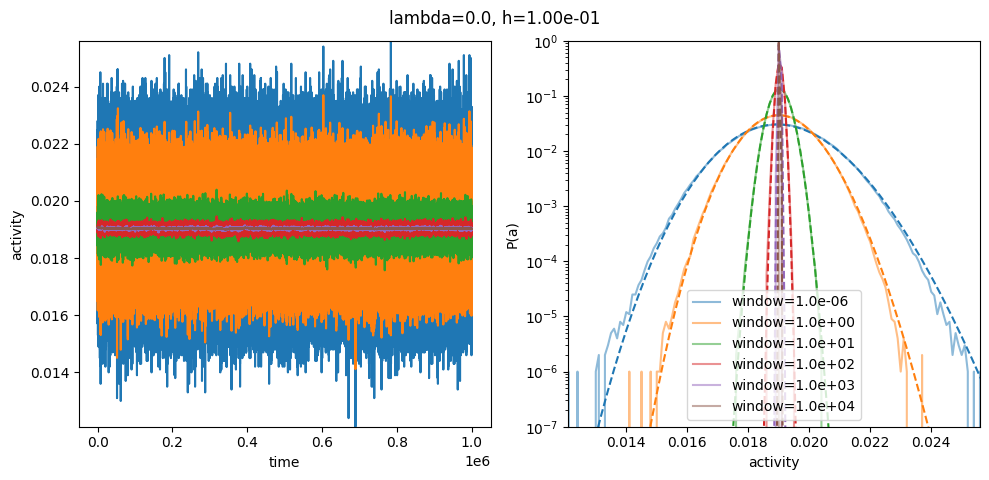

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	2.63e+02,1.08e+04,-0.0001,1.0002,0.023751925970202425,0.023656683899999996
1.0	5.70e+02,2.34e+04,-0.0001,1.0002,0.02375192960925194,0.023656685038468284
10.0	5.24e+03,2.15e+05,-0.0001,1.0002,0.02375193198781178,0.023656686850945248
100.0	5.03e+04,2.07e+06,-0.0001,1.0002,0.02375193288809729,0.023656687741348027
1000.0	4.16e+05,1.71e+07,-0.0001,1.0002,0.023752003416054684,0.023656758282687516
10000.0	1.73e+06,7.13e+07,-0.0001,1.0002,0.023752140567507907,0.02365689546152177


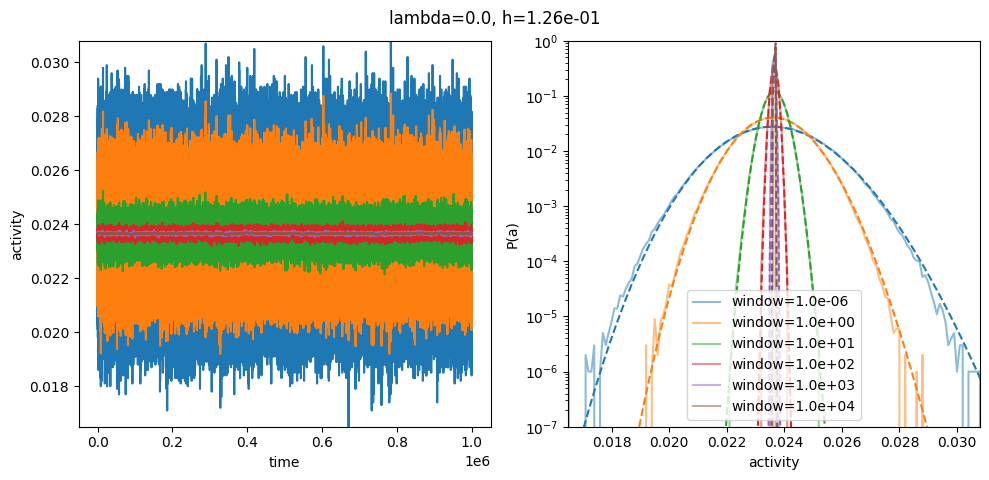

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	3.34e+02,1.10e+04,-0.0001,1.0002,0.029405562820201094,0.029311451300000006
1.0	7.24e+02,2.39e+04,-0.0001,1.0002,0.0294055657990971,0.029311451920887473
10.0	6.64e+03,2.19e+05,-0.0001,1.0002,0.029405565764704187,0.02931145135361312
100.0	6.41e+04,2.12e+06,-0.0001,1.0002,0.029405554337598817,0.029311439914974435
1000.0	5.35e+05,1.77e+07,-0.0001,1.0002,0.029405626354769055,0.029311511945985042
10000.0	2.45e+06,8.10e+07,-0.0001,1.0002,0.02940580839564914,0.029311694023207442


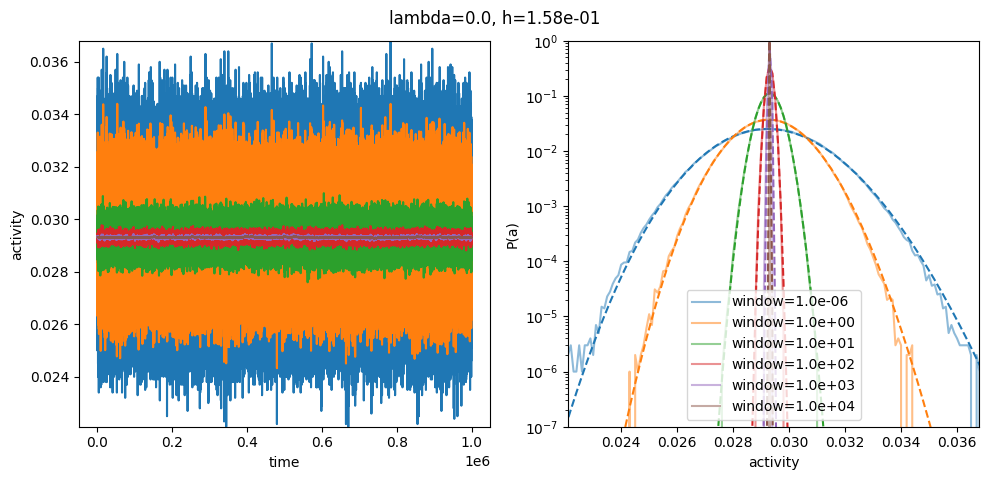

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	4.27e+02,1.13e+04,-0.0001,1.0002,0.03626756605156973,0.03617482679999998
1.0	9.25e+02,2.46e+04,-0.0001,1.0002,0.03626756856736002,0.036174827058931054
10.0	8.52e+03,2.26e+05,-0.0001,1.0002,0.036267566610883525,0.03617482459668062
100.0	8.28e+04,2.20e+06,-0.0001,1.0002,0.03626755214741701,0.03617481012361375
1000.0	7.25e+05,1.93e+07,-0.0001,1.0002,0.036267584067232135,0.036174842050001335
10000.0	3.40e+06,9.04e+07,-0.0001,1.0002,0.03626744776317747,0.036174705718632946


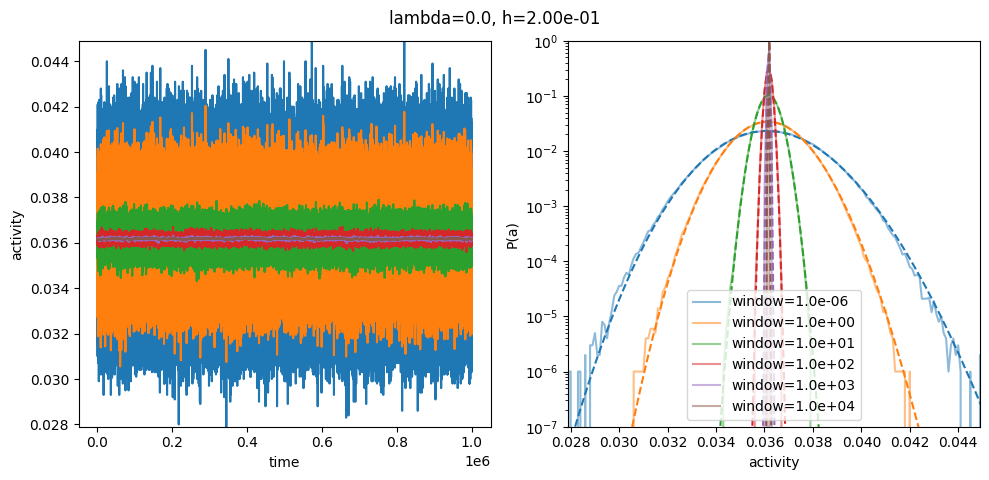

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	5.47e+02,1.17e+04,-0.0001,1.0002,0.04451432406423205,0.044423234000000006
1.0	1.19e+03,2.54e+04,-0.0001,1.0002,0.04451432600695977,0.044423233859612596
10.0	1.09e+04,2.34e+05,-0.0001,1.0002,0.04451432365482919,0.04442323099368018
100.0	1.07e+05,2.29e+06,-0.0001,1.0002,0.044514314012764115,0.044423221341731454
1000.0	9.87e+05,2.12e+07,-0.0001,1.0002,0.044514345432143776,0.04442325276719178
10000.0	5.05e+06,1.08e+08,-0.0001,1.0002,0.04451502310786084,0.04442393057838824


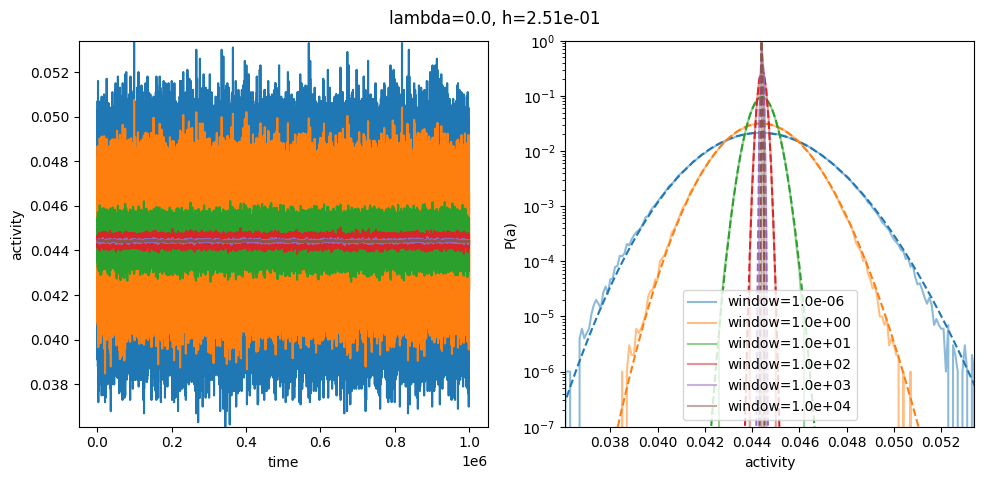

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	7.06e+02,1.23e+04,-0.0001,1.0002,0.05430890679762635,0.054219775500000025
1.0	1.53e+03,2.66e+04,-0.0001,1.0002,0.054308908239886794,0.05421977494945124
10.0	1.41e+04,2.45e+05,-0.0001,1.0002,0.054308901586639376,0.05421976783860402
100.0	1.37e+05,2.38e+06,-0.0001,1.0002,0.054308893087690845,0.05421974708605139
1000.0	1.26e+06,2.20e+07,-0.0001,1.0002,0.05430887053019548,0.0542197367702001
10000.0	7.05e+06,1.23e+08,-0.0001,1.0002,0.05430935773730135,0.05422022407475363


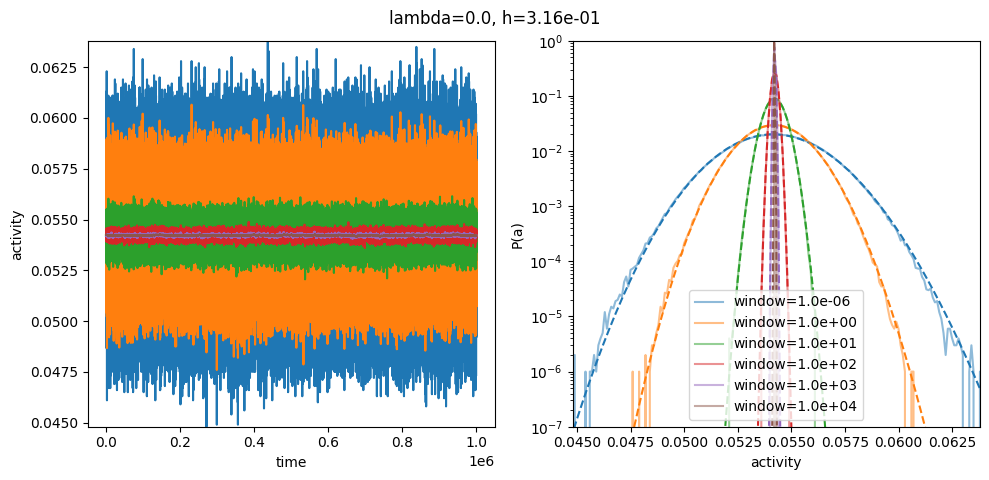

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	9.17e+02,1.30e+04,-0.0001,1.0002,0.06577108224092786,0.06568424310000003
1.0	1.98e+03,2.82e+04,-0.0001,1.0002,0.0657710832279035,0.06568424231567205
10.0	1.83e+04,2.60e+05,-0.0001,1.0002,0.06577107507282703,0.06568423375454864
100.0	1.78e+05,2.53e+06,-0.0001,1.0002,0.06577104820856407,0.06568420688404356
1000.0	1.68e+06,2.39e+07,-0.0001,1.0002,0.0657710000749686,0.06568415874090208
10000.0	1.01e+07,1.44e+08,-0.0001,1.0002,0.06577104697947313,0.06568420565477655


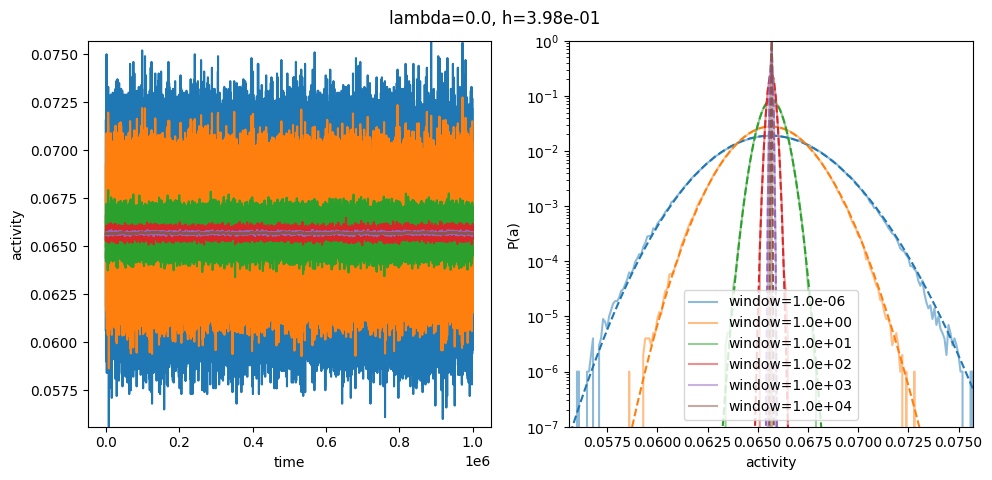

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	1.20e+03,1.40e+04,-0.0001,1.0002,0.07892355698758645,0.07883934810000003
1.0	2.60e+03,3.03e+04,-0.0001,1.0002,0.07892355742966276,0.07883934698490148
10.0	2.41e+04,2.81e+05,-0.0001,1.0002,0.07892354855134057,0.07883933773405938
100.0	2.36e+05,2.76e+06,-0.0001,1.0002,0.07892352968708843,0.07883931885911741
1000.0	2.30e+06,2.69e+07,-0.0001,1.0002,0.0789235021746475,0.07883929134095907
10000.0	1.37e+07,1.60e+08,-0.0001,1.0002,0.07892341025729994,0.07883919940522453


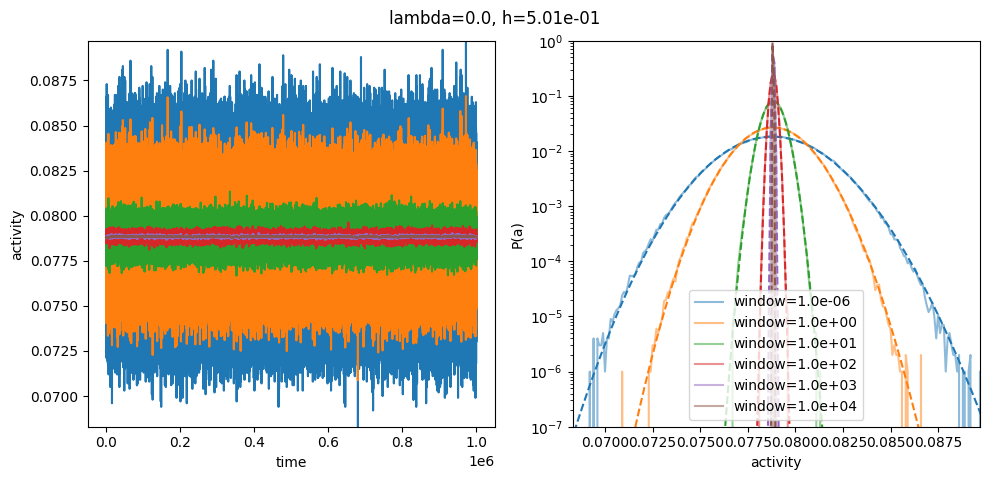

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	1.60e+03,1.54e+04,-0.0001,1.0002,0.09366510654993151,0.09358384579999998
1.0	3.45e+03,3.34e+04,-0.0001,1.0002,0.09366510731064386,0.09358384515800663
10.0	3.19e+04,3.09e+05,-0.0001,1.0002,0.09366510037941078,0.09358383787044003
100.0	3.15e+05,3.05e+06,-0.0001,1.0002,0.09366508058846401,0.09358381807063154
1000.0	3.09e+06,2.99e+07,-0.0001,1.0002,0.09366505941277332,0.09358379689051778
10000.0	1.64e+07,1.59e+08,-0.0001,1.0002,0.09366411585862677,0.09358285314779737


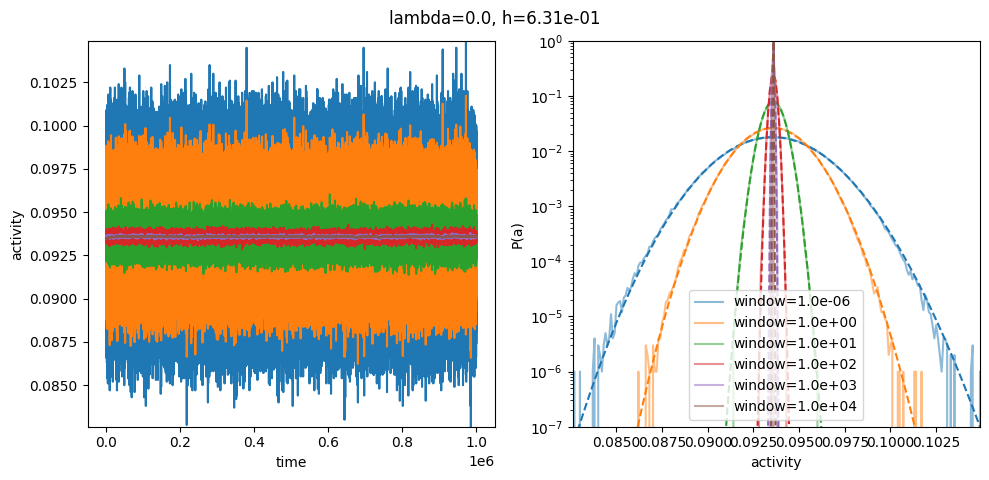

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	2.16e+03,1.76e+04,-0.0001,1.0002,0.10970254088455071,0.1096244874
1.0	4.68e+03,3.80e+04,-0.0001,1.0002,0.10970254127464256,0.1096244865766218
10.0	4.32e+04,3.51e+05,-0.0001,1.0002,0.1097025366891643,0.10962448166768057
100.0	4.27e+05,3.46e+06,-0.0001,1.0002,0.1097025305551475,0.10962447552721767
1000.0	4.12e+06,3.34e+07,-0.0001,1.0002,0.10970254300829324,0.10962448798277181
10000.0	2.59e+07,2.10e+08,-0.0001,1.0002,0.10970213952030565,0.10962408441410151


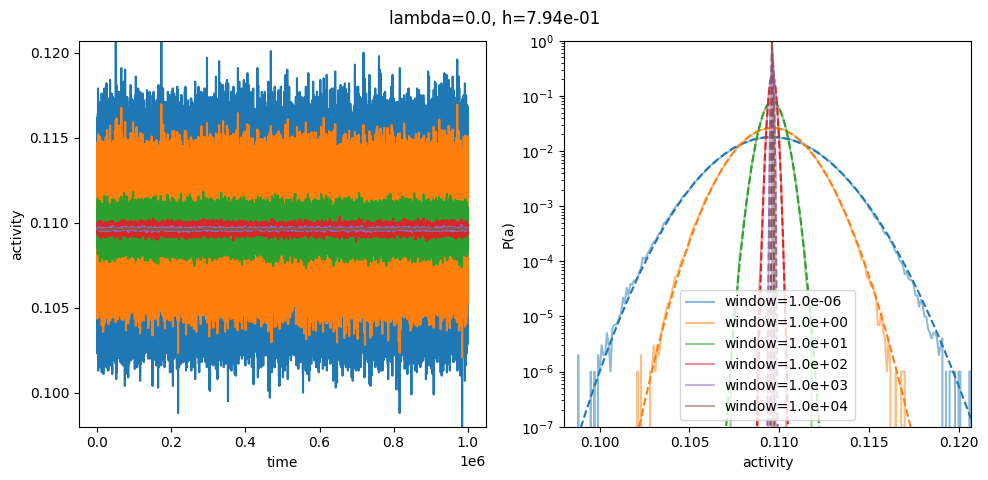

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	3.01e+03,2.08e+04,-0.0001,1.0002,0.126500397620752,0.12642570350000001
1.0	6.51e+03,4.49e+04,-0.0001,1.0002,0.12650039925672346,0.12642570411406362
10.0	6.01e+04,4.15e+05,-0.0001,1.0002,0.12650039806577,0.12642570261778746
100.0	5.96e+05,4.11e+06,-0.0001,1.0002,0.12650038938738034,0.12642569393144265
1000.0	5.75e+06,3.97e+07,-0.0001,1.0002,0.12650041157751465,0.1264257161257272
10000.0	3.27e+07,2.26e+08,-0.0001,1.0002,0.12649957695920586,0.1264248813405041


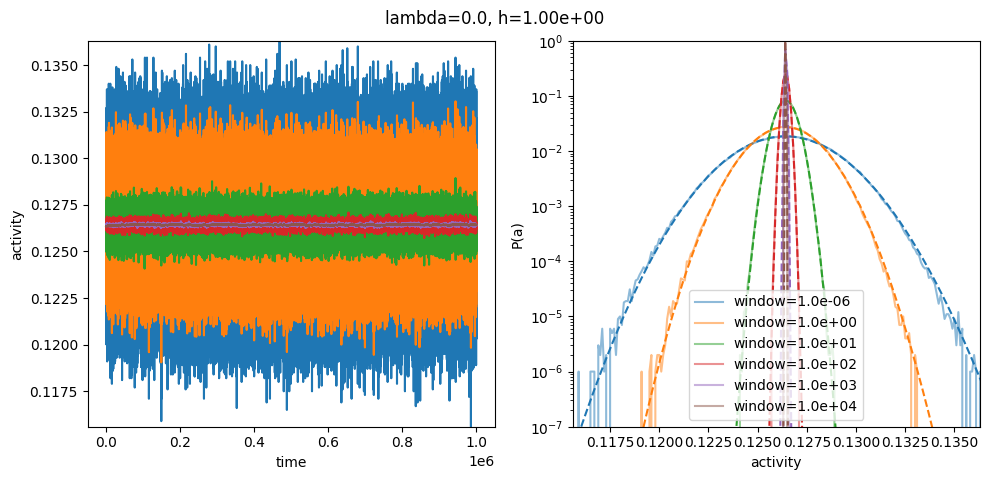

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	4.32e+03,2.58e+04,-0.0001,1.0002,0.14327878781278522,0.14320744910000002
1.0	9.35e+03,5.59e+04,-0.0001,1.0002,0.14327879030322418,0.14320745077971192
10.0	8.63e+04,5.16e+05,-0.0001,1.0002,0.14327879011771058,0.14320745034610466
100.0	8.46e+05,5.06e+06,-0.0001,1.0002,0.14327878055341658,0.14320744077563463
1000.0	8.11e+06,4.85e+07,-0.0001,1.0002,0.14327880723548067,0.14320746746281485
10000.0	4.59e+07,2.75e+08,-0.0001,1.0002,0.14327809166250718,0.14320675174674344


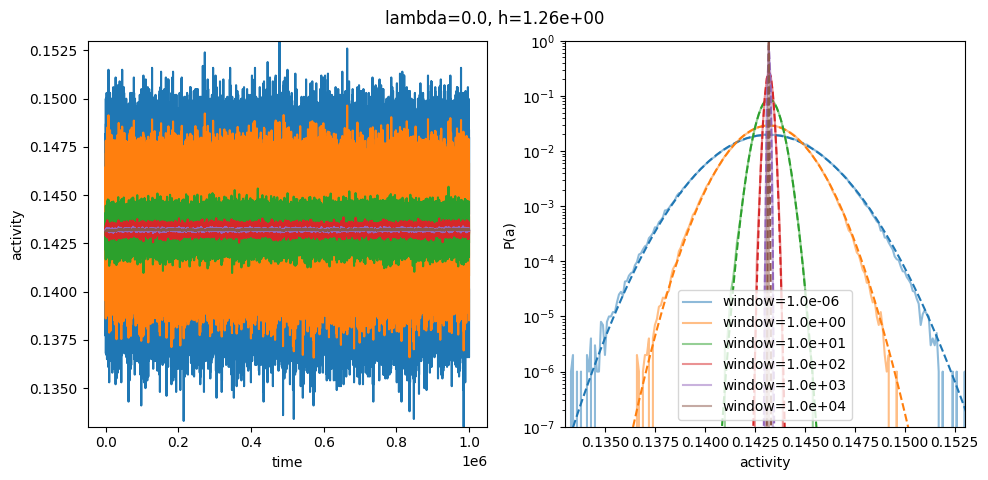

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	6.53e+03,3.45e+04,-0.0001,1.0002,0.15907199562854119,0.15900381530000002
1.0	1.41e+04,7.48e+04,-0.0001,1.0002,0.15907199815498657,0.15900381722867474
10.0	1.31e+05,6.92e+05,-0.0001,1.0002,0.15907200175115116,0.15900382062086862
100.0	1.29e+06,6.81e+06,-0.0001,1.0002,0.15907200103569175,0.15900381990198806
1000.0	1.19e+07,6.27e+07,-0.0001,1.0002,0.15907201928586845,0.15900383815563562
10000.0	6.12e+07,3.24e+08,-0.0001,1.0002,0.15907144192260148,0.15900326067689205


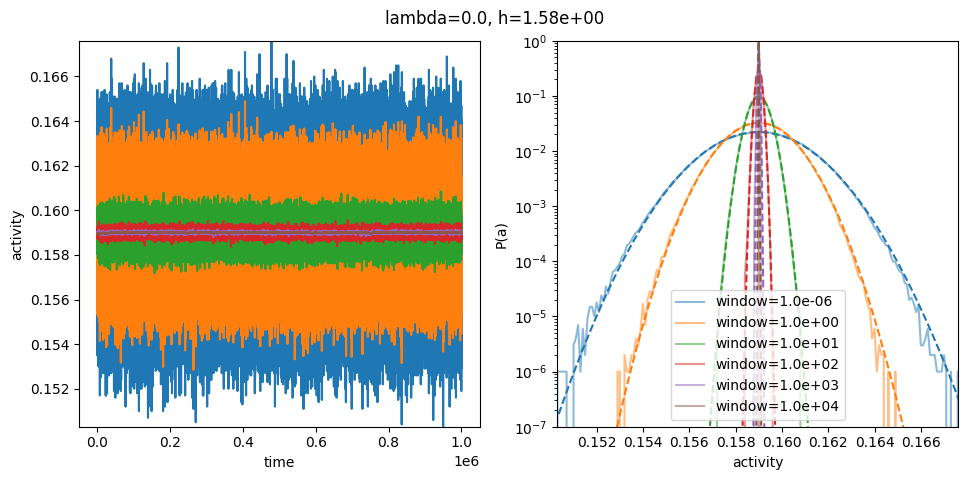

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	1.05e+04,5.04e+04,-0.0001,1.0002,0.17286803099132486,0.17280260959999996
1.0	2.28e+04,1.09e+05,-0.0001,1.0002,0.17286803255476657,0.17280261076731862
10.0	2.11e+05,1.01e+06,-0.0001,1.0002,0.172868037116711,0.1728026151925811
100.0	2.07e+06,9.93e+06,-0.0001,1.0002,0.17286802652228744,0.17280260459357777
1000.0	1.79e+07,8.54e+07,-0.0001,1.0002,0.17286800079901854,0.17280257886508738
10000.0	7.76e+07,3.71e+08,-0.0001,1.0002,0.17286758159745017,0.17280215957967443


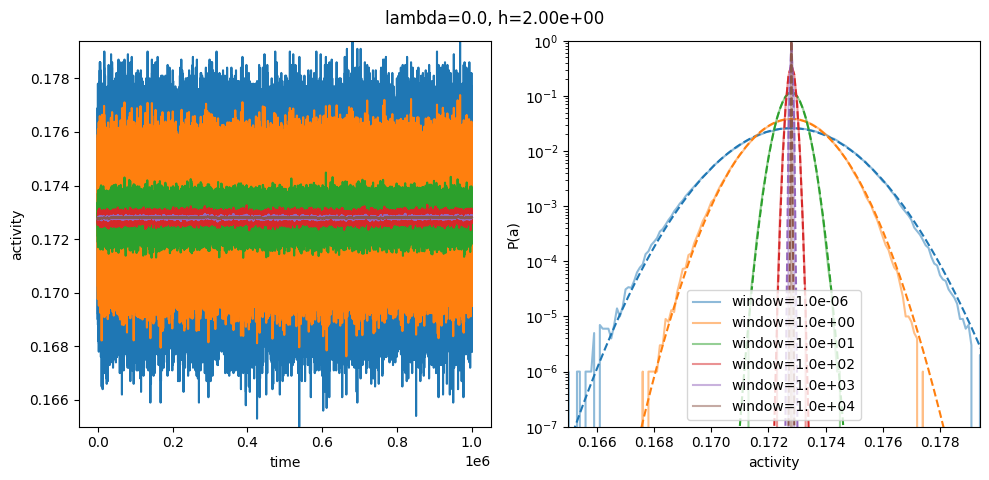

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	1.85e+04,8.21e+04,-0.0001,1.0002,0.18383942341984338,0.1837761961
1.0	4.00e+04,1.78e+05,-0.0001,1.0002,0.18383942434200365,0.18377619677685805
10.0	3.69e+05,1.64e+06,-0.0001,1.0002,0.1838394259833151,0.18377619833545566
100.0	3.61e+06,1.60e+07,-0.0001,1.0002,0.18383941400201964,0.18377618635070667
1000.0	2.79e+07,1.24e+08,-0.0001,1.0002,0.18383938644249245,0.1837761587856861
10000.0	1.02e+08,4.54e+08,-0.0001,1.0002,0.18383932931222943,0.18377610164399613


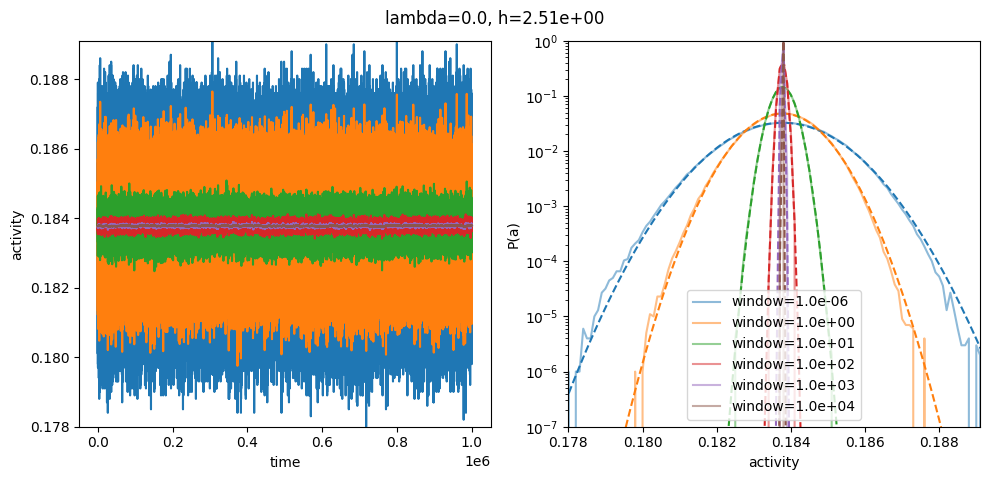

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	3.66e+04,1.54e+05,-0.0001,1.0002,0.1915967214052393,0.1915350453999999
1.0	7.91e+04,3.34e+05,-0.0001,1.0002,0.19159673427825658,0.1915350458930528
10.0	7.25e+05,3.06e+06,-0.0001,1.0002,0.19159672448116127,0.1915350482925337
100.0	6.88e+06,2.90e+07,-0.0001,1.0002,0.19159671482444338,0.19153503863331361
1000.0	4.83e+07,2.04e+08,-0.0001,1.0002,0.19159671602912878,0.191535039838239
10000.0	1.21e+08,5.11e+08,-0.0001,1.0002,0.19159660506813567,0.19153492885505302


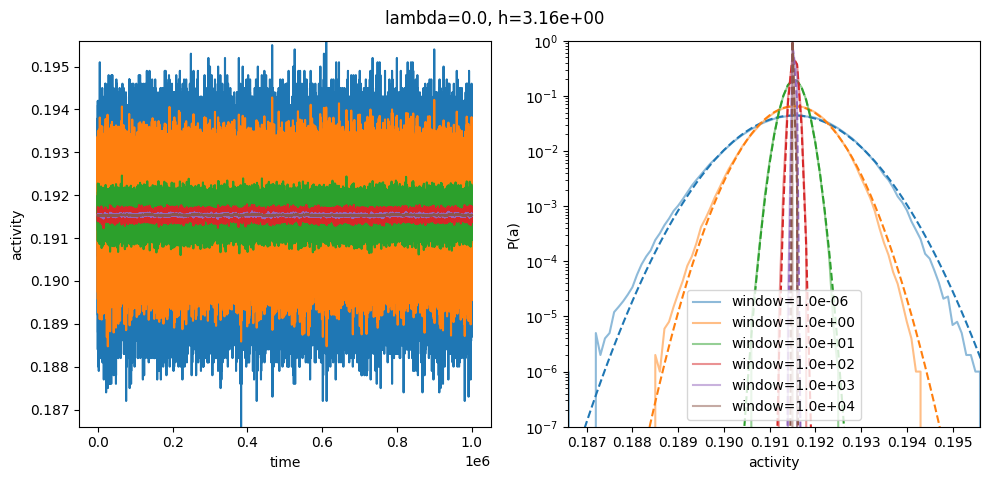

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	8.44e+04,3.45e+05,-0.0001,1.0002,0.19632768631754793,0.1962669564
1.0	1.82e+05,7.47e+05,-0.0001,1.0002,0.1963276990712964,0.1962669568512847
10.0	1.68e+06,6.88e+06,-0.0001,1.0002,0.19632769029331248,0.1962669602975362
100.0	1.53e+07,6.28e+07,-0.0001,1.0002,0.19632769115886764,0.19626696116300843
1000.0	7.95e+07,3.25e+08,-0.0001,1.0002,0.19632770390159016,0.19626697390827477
10000.0	1.39e+08,5.69e+08,-0.0001,1.0002,0.19632776075686015,0.19626703077491536


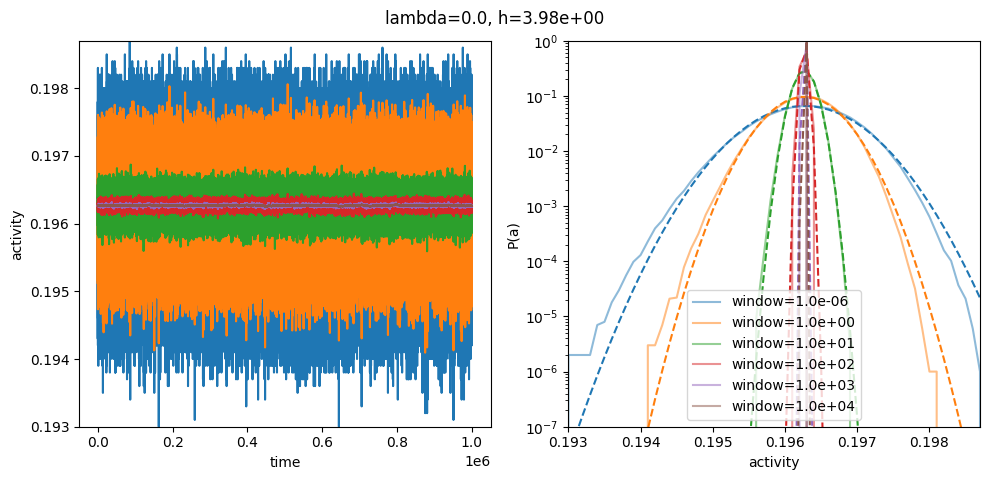

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	2.39e+05,9.65e+05,-0.0001,1.0002,0.19872908768915465,0.19866883799999996
1.0	5.18e+05,2.09e+06,-0.0001,1.0002,0.1987290874927876,0.19866883778344976
10.0	4.68e+06,1.89e+07,-0.0001,1.0002,0.1987290867180058,0.1986688370013474
100.0	3.65e+07,1.47e+08,-0.0001,1.0002,0.19872908476245774,0.19866883504531554
1000.0	1.17e+08,4.70e+08,-0.0001,1.0002,0.1987290874954025,0.19866883777880615
10000.0	1.50e+08,6.06e+08,-0.0001,1.0002,0.19872918523949304,0.19866893554244475


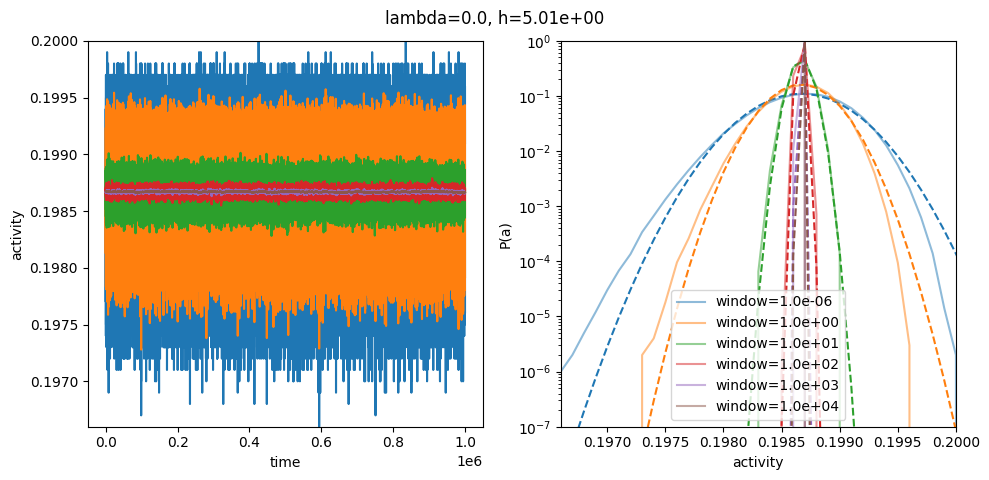

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	8.75e+05,3.51e+06,-0.0001,1.0002,0.1996962397786128,0.19963618349999998
1.0	1.88e+06,7.55e+06,-0.0001,1.0002,0.19969623970061304,0.19963618341646006
10.0	1.44e+07,5.75e+07,-0.0001,1.0002,0.199696251669611,0.19963618313955173
100.0	8.33e+07,3.34e+08,-0.0001,1.0002,0.19969624047769508,0.1996361841916944
1000.0	1.44e+08,5.78e+08,-0.0001,1.0002,0.19969624561770508,0.19963618933273244
10000.0	1.54e+08,6.19e+08,-0.0001,1.0002,0.19969614644825118,0.19963609014344483


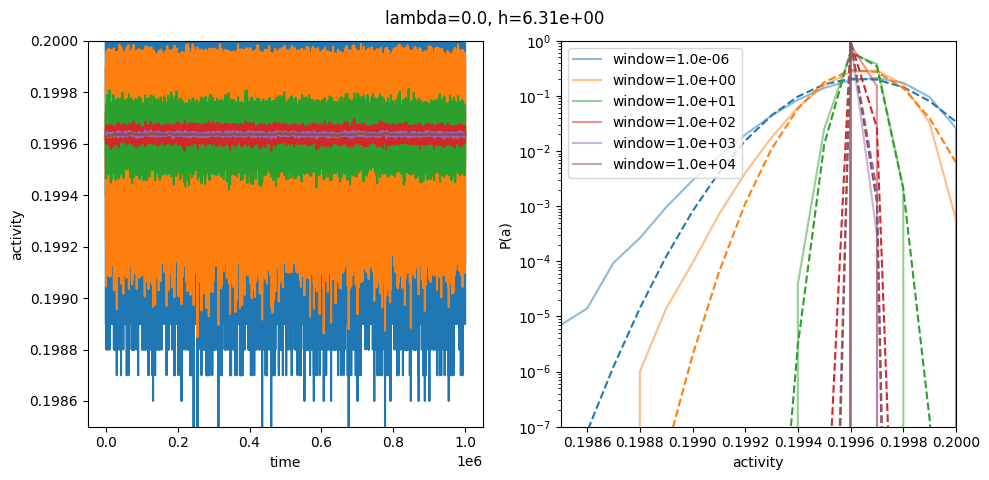

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	4.15e+06,1.66e+07,-0.0001,1.0002,0.1999890101051733,0.19992900430000002
1.0	7.44e+06,2.98e+07,-0.0001,1.0002,0.19998899244725865,0.19992900428932986
10.0	5.75e+07,2.30e+08,-0.0001,1.0002,0.1999890020885619,0.19992900435488817
100.0	1.34e+08,5.34e+08,-0.0001,1.0002,0.19998900328628028,0.1999290055528415
1000.0	1.54e+08,6.16e+08,-0.0001,1.0002,0.19998900344189893,0.199929005708491
10000.0	1.56e+08,6.25e+08,-0.0001,1.0002,0.19998898754400293,0.19992898980741575


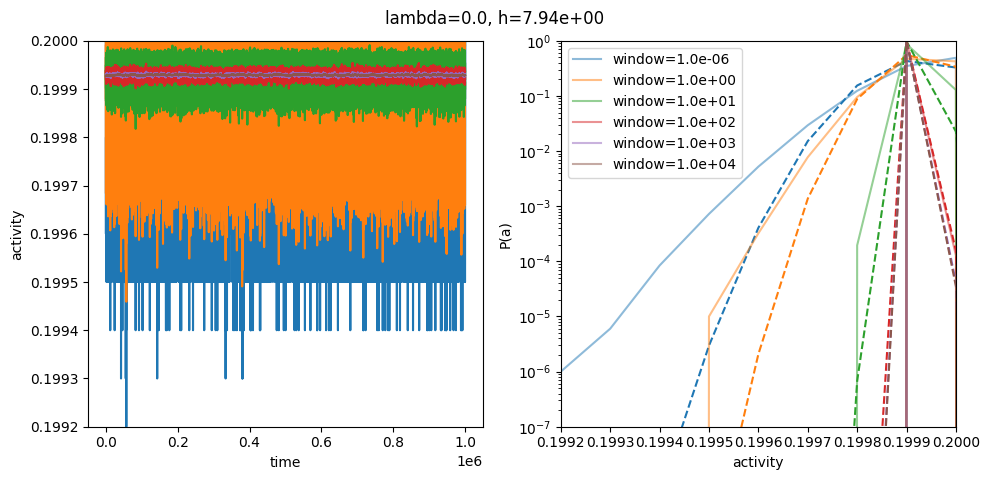

[1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
1e-06	1.26e+07,5.04e+07,-0.0001,1.0002,0.20005080952282106,0.19999089099999998
1.0	5.12e+07,2.05e+08,-0.0001,1.0002,0.2000508763587743,0.19999089100000003
10.0	1.28e+08,5.13e+08,-0.0001,1.0002,0.20005087633515958,0.19999089097633177
100.0	1.53e+08,6.13e+08,-0.0001,1.0002,0.2000508764314065,0.19999089107259665
1000.0	1.56e+08,6.25e+08,-0.0001,1.0002,0.20005087672301894,0.19999089136426723
10000.0	1.57e+08,6.26e+08,-0.0001,1.0002,0.20005088206296404,0.1999908967052813


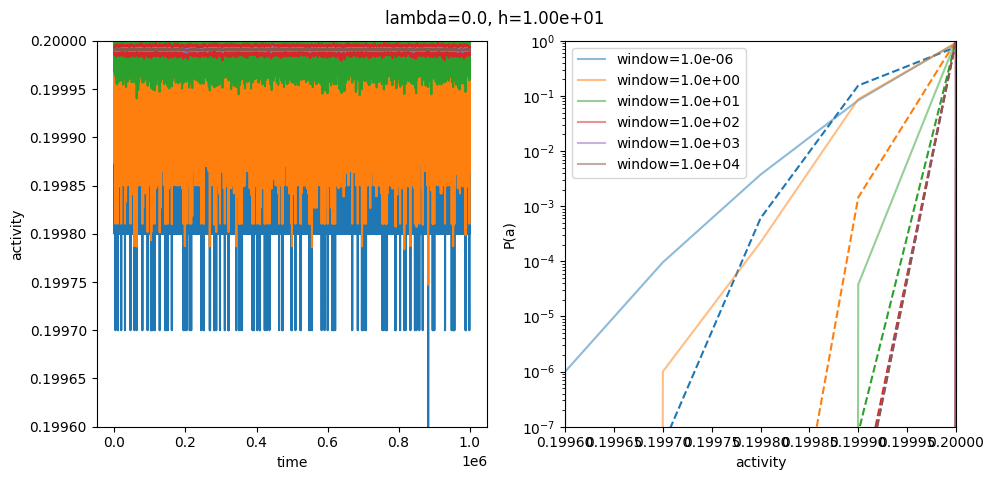

In [ ]:
plot_flag=True
for (h,file) in zip(hs, filenames):
    filename = path+'/'+file

    # make figures for quality check
    if plot_flag:
        fig, axes = plt.subplots(1,2, figsize=(10,5))
        range_data = [1,0]

    # open hdf5 file
    with h5py.File(filename, 'r') as file:
        N = file.attrs['N']
        lambda_ = file.attrs['lambda']
        h=file.attrs['h']
        delta = 1/N
        support = np.linspace(0,1,N+1)
        if plot_flag:
            # set title in center of figure
            title_str = f'lambda={lambda_}, h={h:.2e}'
            fig.suptitle(title_str, y=.95)
        # windows
        windows = np.array(file['windows'])
        print(windows)
        for (i,window) in enumerate(windows):
            data = np.array(file['samples'][f'{window}'])
            if plot_flag:
                axes[0].plot(data)
                pmf_data = np.histogram(data, bins=np.append(support,1+delta)-delta/2, density=False)[0]/len(data)
                ref = axes[1].plot(support, pmf_data, label=f'window={windows[i]:.1e}', alpha=0.5)
            # fit beta distribution
            a,b,loc,scale = fit_beta_distribution(data, delta)
            # add result to hdf5 file; TODO: check if this is better done with a table maybe even in an sqllite database?
            with h5py.File(file_beta, 'a') as out:
                dset = f'{window}/{lambda_}/{h}'
                if dset in out:
                    del out[dset]
                out.create_dataset(dset, data=np.array([a,b,loc,scale, a/(a+b), np.mean(data)]))            

            print(f'{window}\t{a:.2e},{b:.2e},{loc},{scale},{a/(a+b)},{np.mean(data)}')


            if plot_flag:
                pmf_beta = stats.beta.pdf(support, a,b, loc=loc, scale=scale)
                pmf_beta = pmf_beta/np.sum(pmf_beta)
                axes[1].plot(support,pmf_beta, color=ref[0].get_color(), linestyle='--')
                range_data[0] = min(range_data[0], support[np.nonzero(pmf_data)][0])
                range_data[1] = max(range_data[1], support[np.nonzero(pmf_data)][-1])
    if plot_flag:
        axes[0].set_xlabel('time')
        axes[0].set_ylabel('activity')
        axes[1].set_xlabel('activity')
        axes[1].set_ylabel('P(a)')
        # set xrange to range of data
        axes[1].set_yscale('log')
        axes[1].set_ylim([1e-7,1])
        axes[1].set_xlim(range_data)
        axes[0].set_ylim(range_data)
        axes[1].legend()
        plt.tight_layout()
        plt.show()